In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install autogluon==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking

In [ ]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from sklearn.decomposition import PCA
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import math
from optuna.visualization import plot_optimization_history, plot_param_importances

# Data Preprocessing

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/urban_sound_8k"
AUDIO_PATH = os.path.join(DATASET_PATH, "UrbanSound8K/UrbanSound8K/audio")
METADATA_PATH = os.path.join(DATASET_PATH, "UrbanSound8K.csv")

In [ ]:
metadata = pd.read_csv(METADATA_PATH)
metadata.head()


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [ ]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [ ]:
print(metadata.shape)
print(metadata.info())
print(metadata.describe())

(8732, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB
None
                fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     

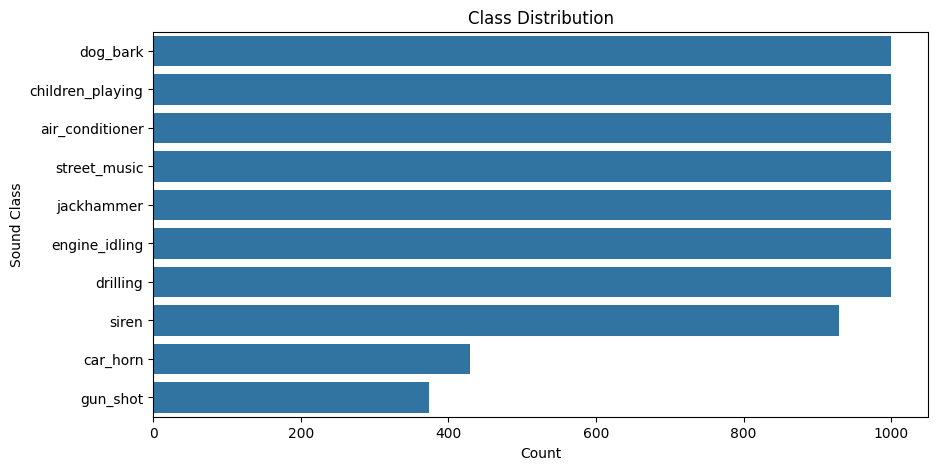

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y=metadata['class'], order=metadata['class'].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Count")
plt.ylabel("Sound Class")
plt.show()

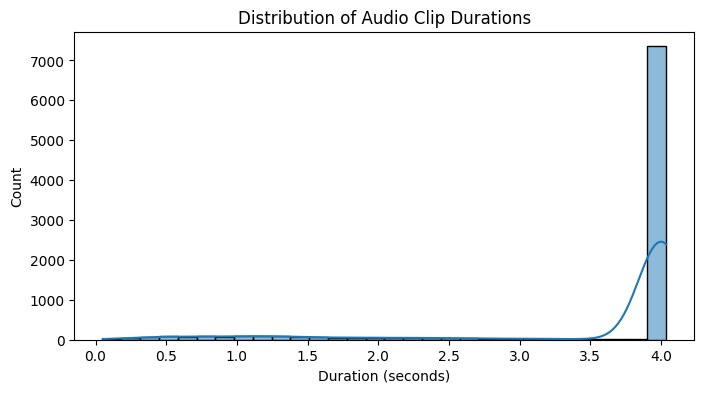

In [ ]:
durations = []
for i, row in metadata.iterrows():
    path = f"{AUDIO_PATH}/fold{row['fold']}/{row['slice_file_name']}"
    y, sr = librosa.load(path)
    durations.append(len(y)/sr)

plt.figure(figsize=(8,4))
sns.histplot(durations, bins=30, kde=True)
plt.title("Distribution of Audio Clip Durations")
plt.xlabel("Duration (seconds)")
plt.show()

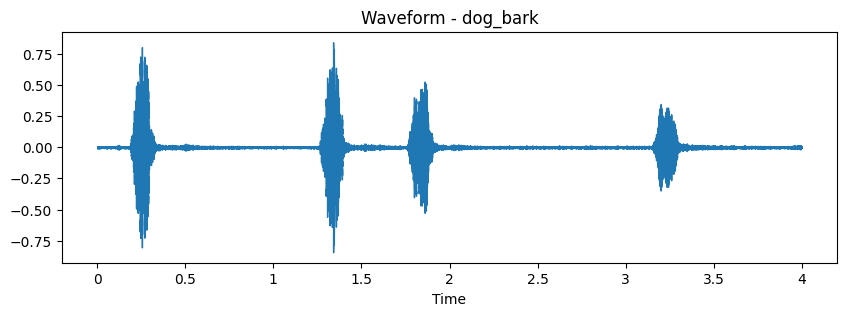

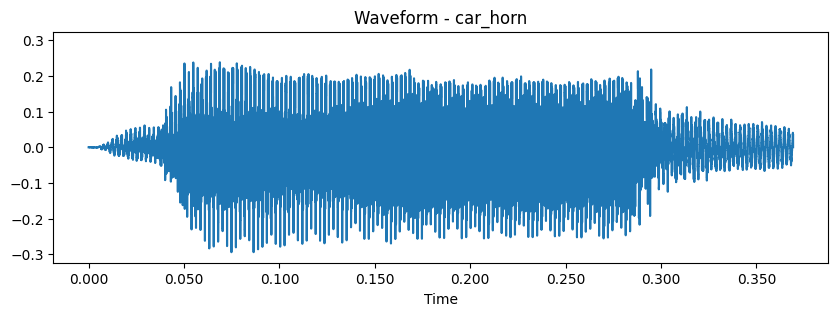

In [ ]:
def plot_waveform(class_name):
    sample = metadata[metadata['class'] == class_name].sample(1).iloc[0]
    path = f"{AUDIO_PATH}/fold{sample['fold']}/{sample['slice_file_name']}"
    y, sr = librosa.load(path)

    plt.figure(figsize=(10,3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {class_name}")
    plt.show()

plot_waveform("dog_bark")
plot_waveform("car_horn")

Some sounds have sharp peaks → impulsive events (gunshot, car horn).

Others have smooth periodic patterns → machinery sounds (engine_idling, air_conditioner).

This visually confirms the spectral diversity in the dataset.

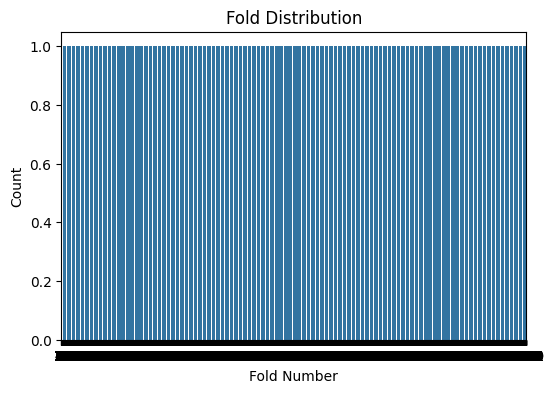

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(metadata['fold'])
plt.title("Fold Distribution")
plt.xlabel("Fold Number")
plt.ylabel("Count")
plt.show()

Each fold contains roughly the same number of samples.

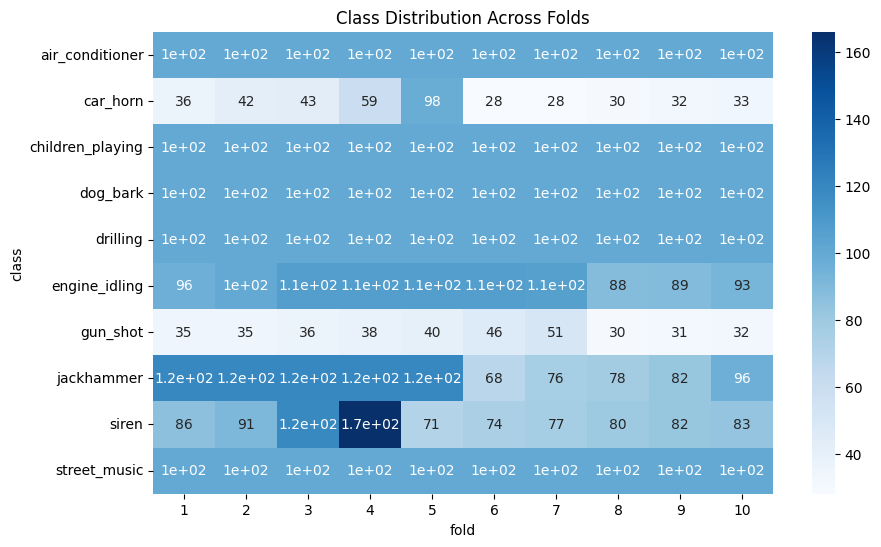

In [ ]:
pivot = pd.pivot_table(metadata, index='class', columns='fold', aggfunc='size', fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="Blues")
plt.title("Class Distribution Across Folds")
plt.show()

Each class is fairly evenly distributed across folds → ensures reliable cross-validation.

Imbalance appears within classes, not across folds.

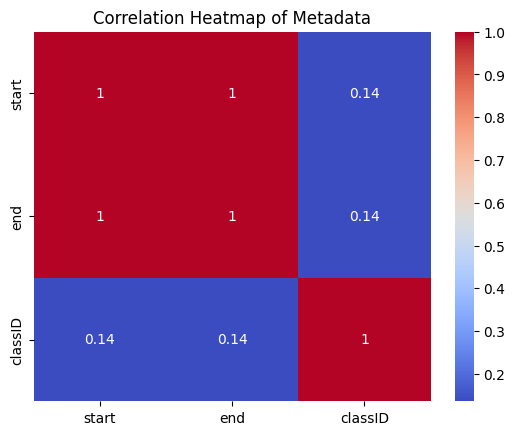

In [ ]:
meta_corr = metadata[['start','end','classID']].corr()
sns.heatmap(meta_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Metadata")
plt.show()

Minimal correlation between timing (start/end) and class.

No metadata leakage concern.

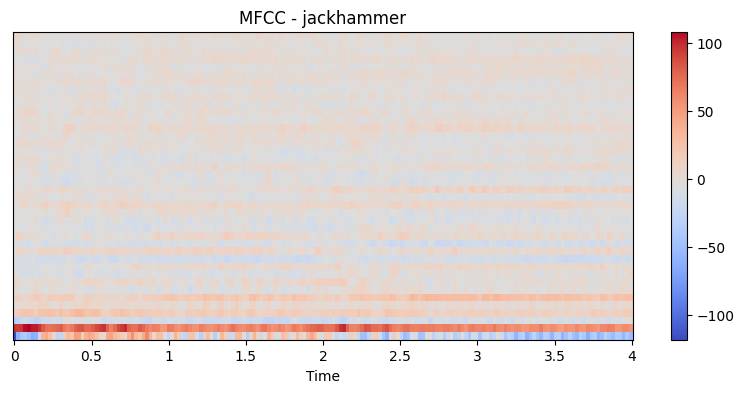

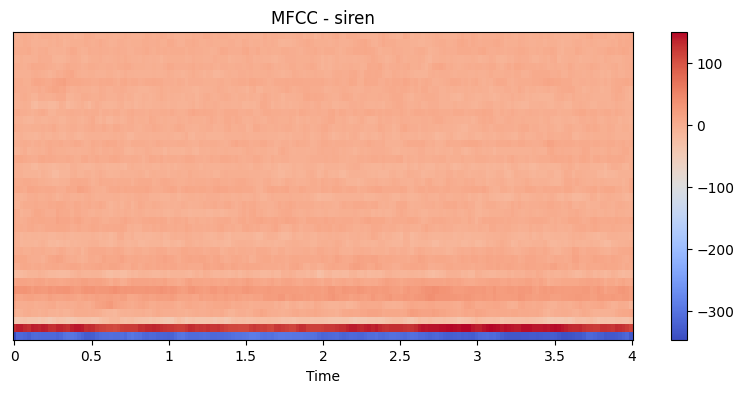

In [ ]:
def plot_mfcc(class_name):
    sample = metadata[metadata['class'] == class_name].sample(1).iloc[0]
    path = f"{AUDIO_PATH}/fold{sample['fold']}/{sample['slice_file_name']}"
    y, sr = librosa.load(path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(f"MFCC - {class_name}")
    plt.show()

plot_mfcc("jackhammer")
plot_mfcc("siren")

Different classes have strongly different MFCC shapes.

Jackhammer shows dense, high-energy MFCC bands.

Siren shows rising/falling frequency patterns.

In [ ]:
def extract_basic_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=120)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        return np.hstack([mfcc_mean, mfcc_std])

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 4. Loop over all audio files and extract features
features = []
labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    fold = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]

    file_path = os.path.join(AUDIO_PATH, f"fold{fold}", file_name)

    mfcc_feat = extract_basic_features(file_path)
    if mfcc_feat is not None:
        features.append(mfcc_feat)
        labels.append(label)

# 5. Convert to DataFrame
df = pd.DataFrame(features)
df['label'] = labels
df.to_csv("/content/drive/MyDrive/urban_sound_features1.csv", index=False)


In [ ]:
# fetch already saved features from drive so we don't have to preprocess data again
df = pd.read_csv("/content/drive/MyDrive/urban_sound_features1.csv")

df.head()

0           1           2          3          4          5  \
0 -211.93698   62.581210 -122.813156 -60.745293 -13.893755 -29.789837   
1 -417.00520   99.336624  -42.995583  51.073326   9.853777   7.969693   
2 -452.39316  112.362530  -37.578070  43.195866   8.631844  15.379368   
3 -406.47922   91.196600  -25.043552  42.784520  11.586844   5.054164   
4 -439.63873  103.862230  -42.658783  50.690285  12.209423  15.873465   

           6          7          8         9  ...        71        72  \
0  -3.978872  11.682741  12.963834  8.336421  ...  3.283029  3.866958   
1  11.197088   1.929117   7.030397  4.270228  ...  6.388739  5.976727   
2  16.882149   1.233047   6.833122  3.900116  ...  5.055295  6.281999   
3  12.431632  -1.599949   6.656064  1.442355  ...  7.489706  7.074054   
4  11.729268   1.533585  11.292241  2.548622  ...  5.916598  4.479704   

         73        74        75        76        77        78        79  \
0  4.620133  3.095600  3.459606  3.520611  3.645866  2.810899  2.532340   
1  4.903100  5.148487  5.155189  4.897051  5.438464  5.740441  5.103922   
2  5.027777  4.486072  4.804223  4.759939  4.926493  4.725787  5.665499   
3  5.844611  6.464928  6.048745  6.338518  5.227894  6.630214  6.184402   
4  4.123765  3.972086  3.870933  4.470607  5.447584  6.197588  4.888763   

              label  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

[5 rows x 81 columns]

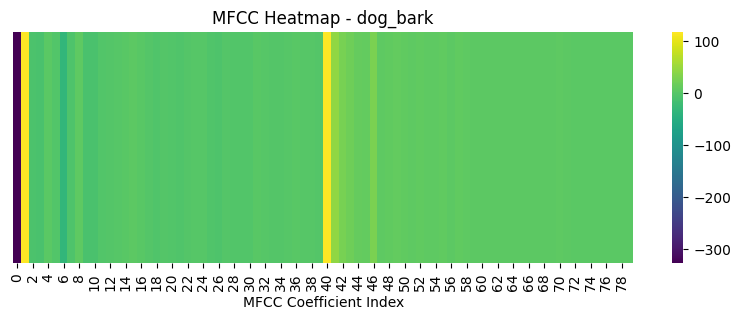

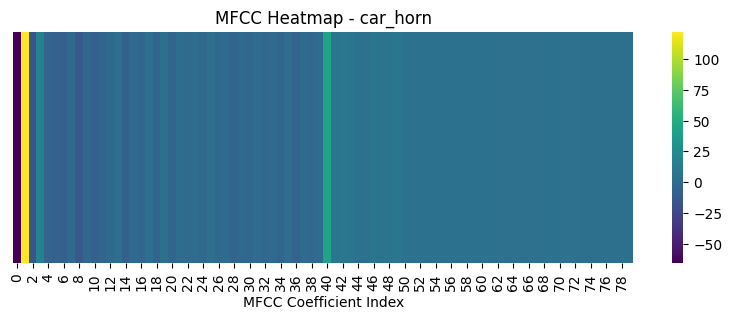

In [ ]:
def plot_mfcc_heatmap(class_name):
    sample = df[df['label'] == class_name].sample(1).iloc[0]
    mfcc_vals = sample.drop('label').astype(float).to_numpy(dtype=float).reshape(1, -1)

    plt.figure(figsize=(10, 3))
    sns.heatmap(mfcc_vals, cmap="viridis", cbar=True)
    plt.title(f"MFCC Heatmap - {class_name}")
    plt.xlabel("MFCC Coefficient Index")
    plt.yticks([])
    plt.show()

plot_mfcc_heatmap("dog_bark")
plot_mfcc_heatmap("car_horn")

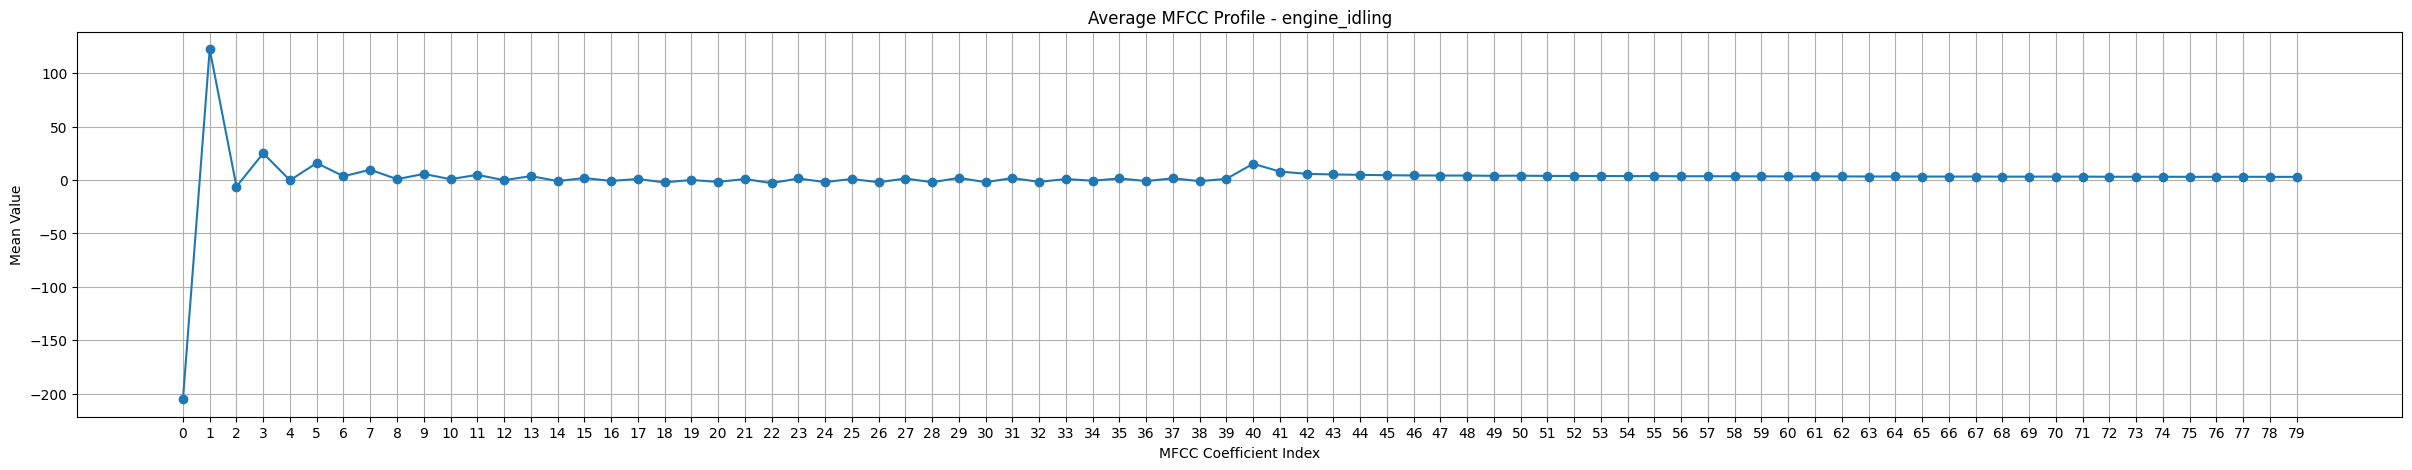

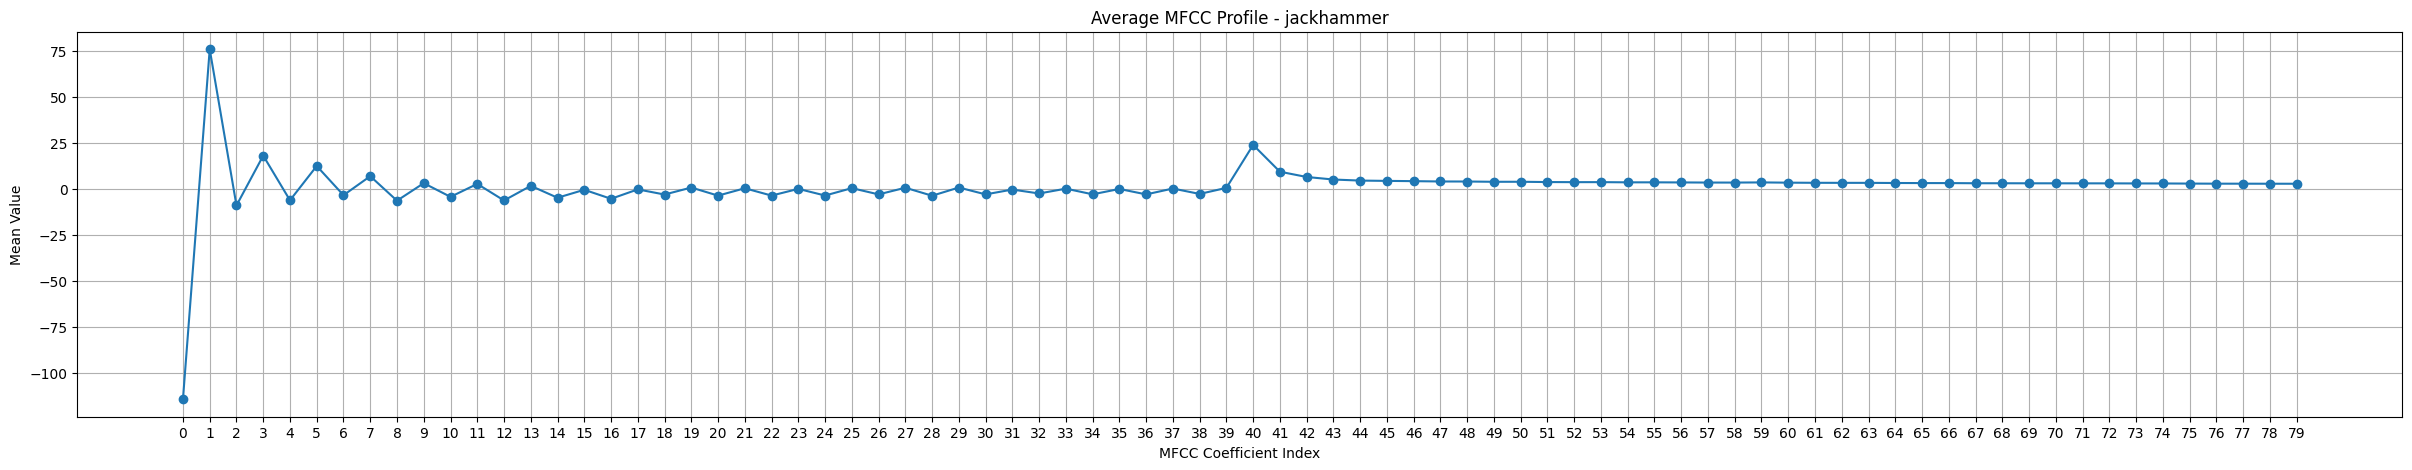

In [ ]:
def plot_class_mfcc_profile(class_name):
    subset = df[df['label'] == class_name].drop('label', axis=1)
    mean_vec = subset.mean(axis=0)

    plt.figure(figsize=(30,5))
    plt.plot(mean_vec, marker='o')
    plt.title(f"Average MFCC Profile - {class_name}")
    plt.xlabel("MFCC Coefficient Index")
    plt.ylabel("Mean Value")
    plt.grid(True)
    plt.show()

plot_class_mfcc_profile("engine_idling")
plot_class_mfcc_profile("jackhammer")

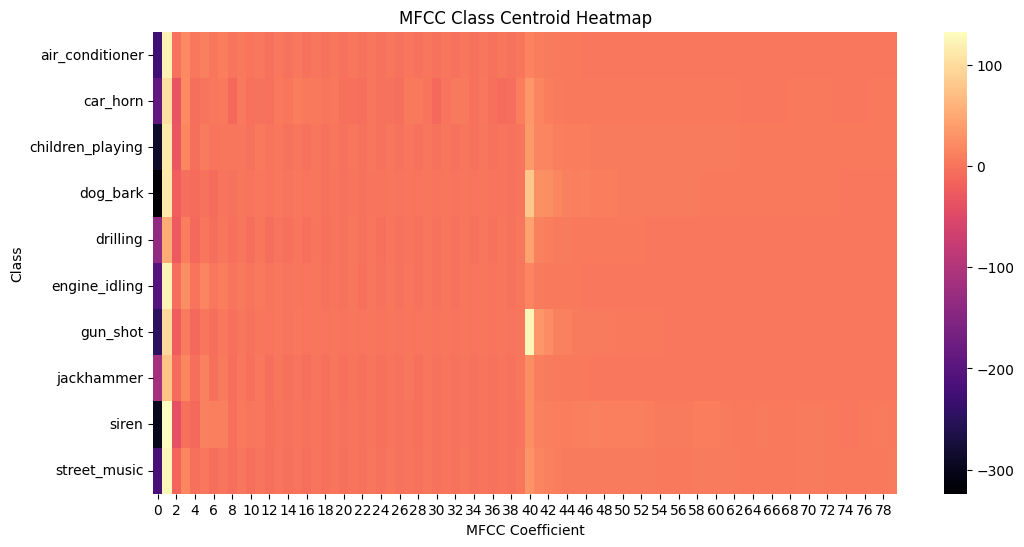

In [ ]:
class_centroids = df.groupby('label').mean()

plt.figure(figsize=(12,6))
sns.heatmap(class_centroids, cmap="magma", annot=False)
plt.title("MFCC Class Centroid Heatmap")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Class")
plt.show()

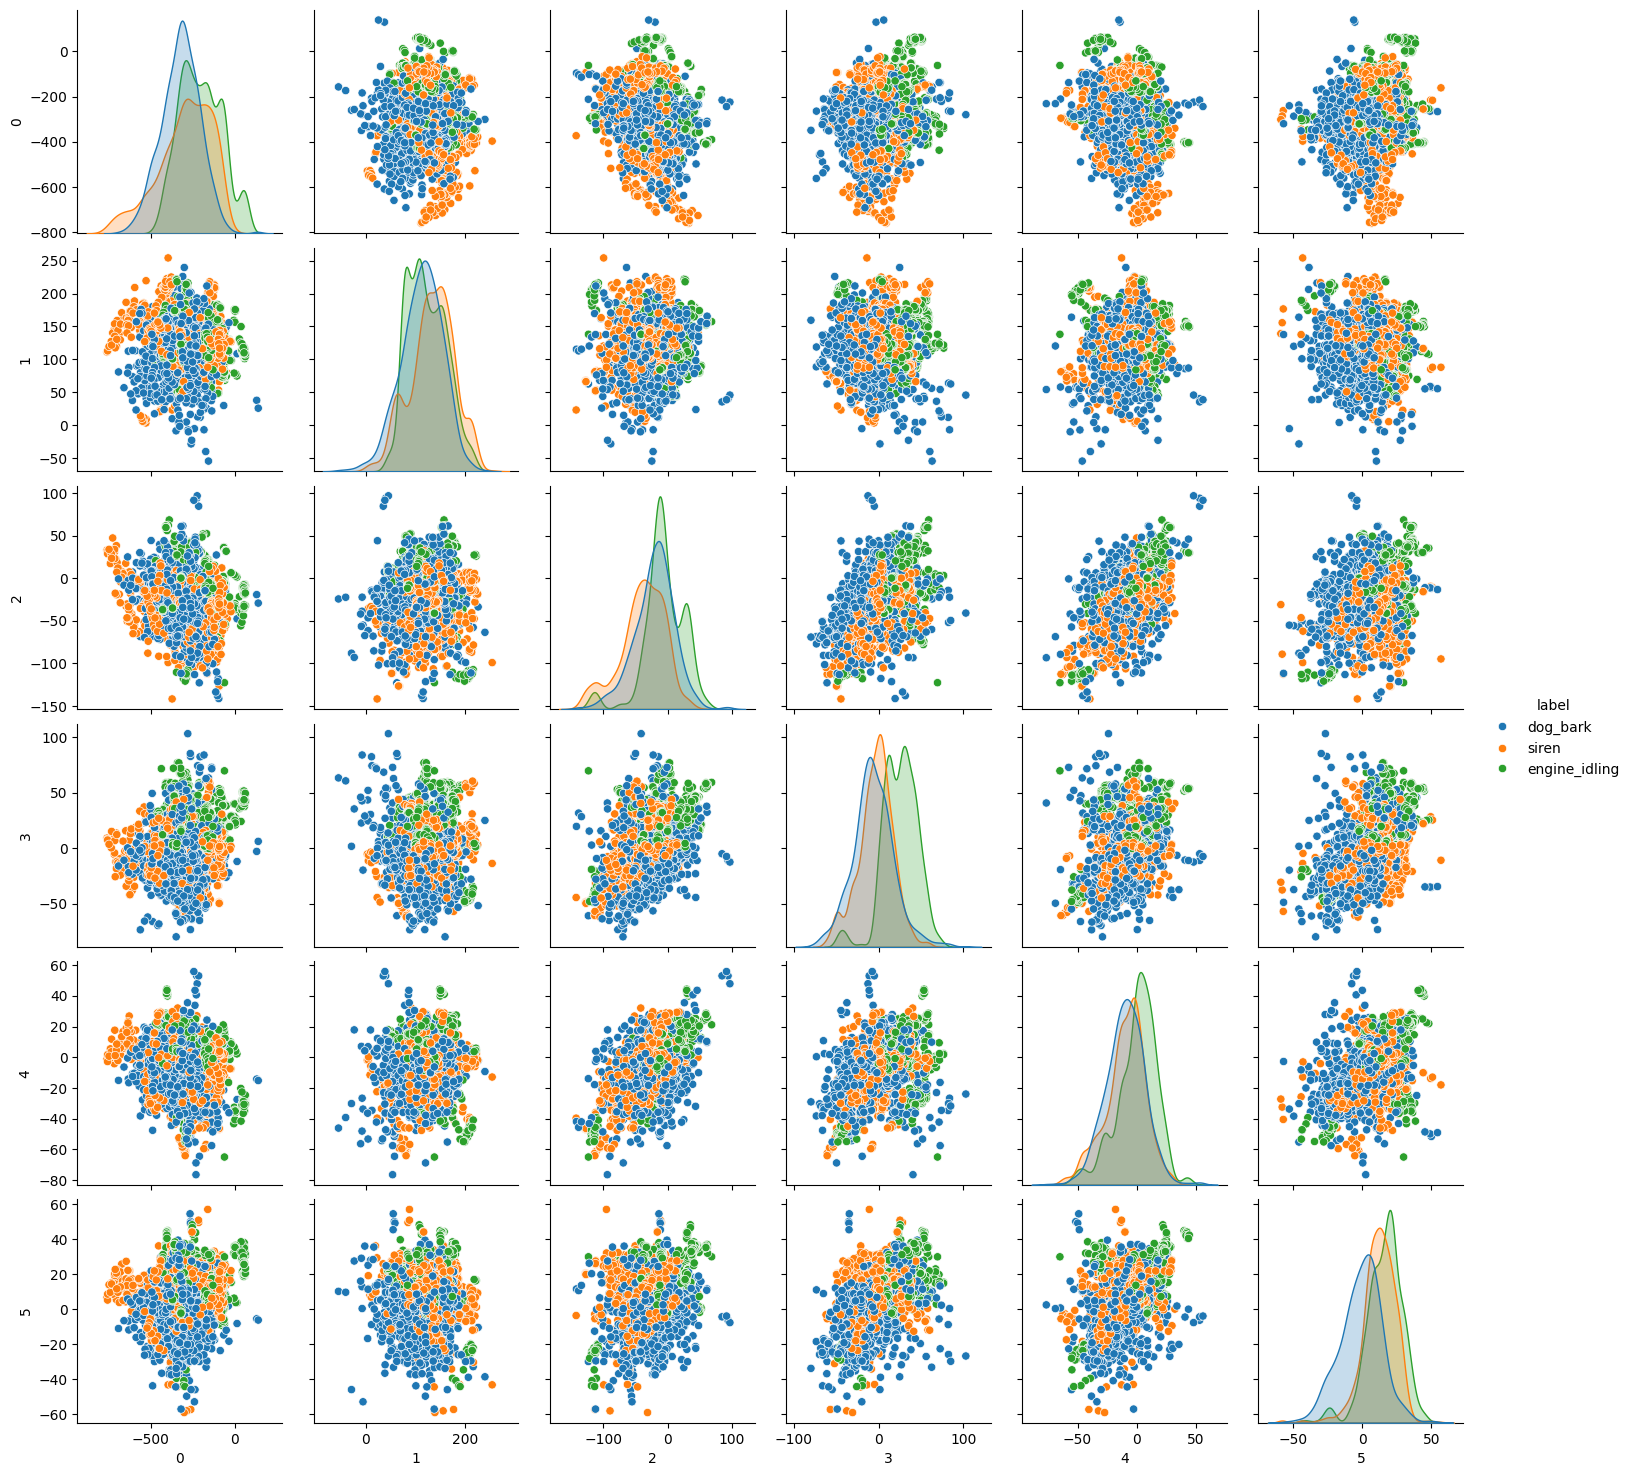

In [ ]:
selected_classes = ["dog_bark", "engine_idling", "siren"]
subset = df[df['label'].isin(selected_classes)]

mfcc_cols = df.columns[df.columns != "label"][:6]
subset_small = subset[mfcc_cols.tolist() + ["label"]]

sns.pairplot(subset_small, hue="label")
plt.show()

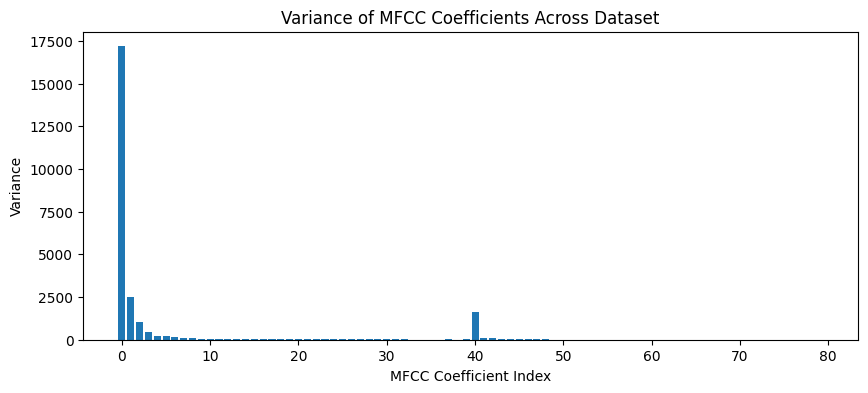

In [ ]:
mfcc_only = df.drop('label', axis=1)
mfcc_var = mfcc_only.var()

plt.figure(figsize=(10,4))
plt.bar(range(80), mfcc_var)
plt.title("Variance of MFCC Coefficients Across Dataset")
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Variance")
plt.show()

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
print(X.shape)

(8732, 137)


In [ ]:
print(np.unique(y_encoded))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Dataset Split into 80% Training and 20% Testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
# Data scaling for Baseline models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Model

Our baseline includes following models:
1. Logistic Regression
2. Support Vector Machine
3. Random Forest Classifier

# Logistic Regression

In [ ]:
log_reg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight="balanced"
)

In [ ]:
log_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [ ]:
y_pred = log_reg.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7464224384659416


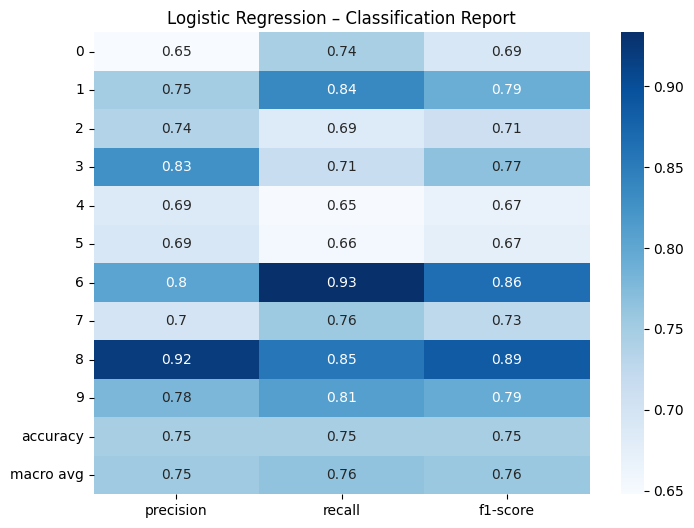

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title("Logistic Regression – Classification Report")
plt.show()

The model shows balanced performance across most classes, achieving an overall precision, recall, and F1-score of around 0.75. Although some classes perform better than others, the model demonstrates reasonably strong generalization for a simple linear classifier.

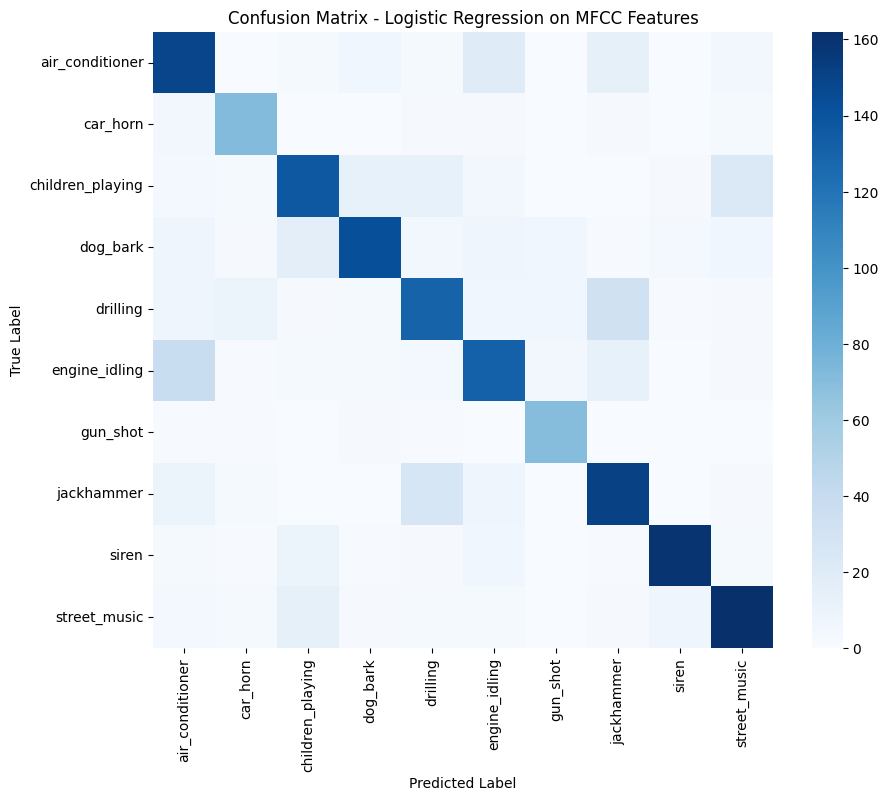

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression on MFCC Features")
plt.show()

The confusion matrix shows that model correctly identifies most samples along the diagonal, but struggles with a few overlapping classes such as car_horn and children_playing. Overall, the model demonstrates reasonable class separation, though some sound categories remain challenging due to similar acoustic patterns.

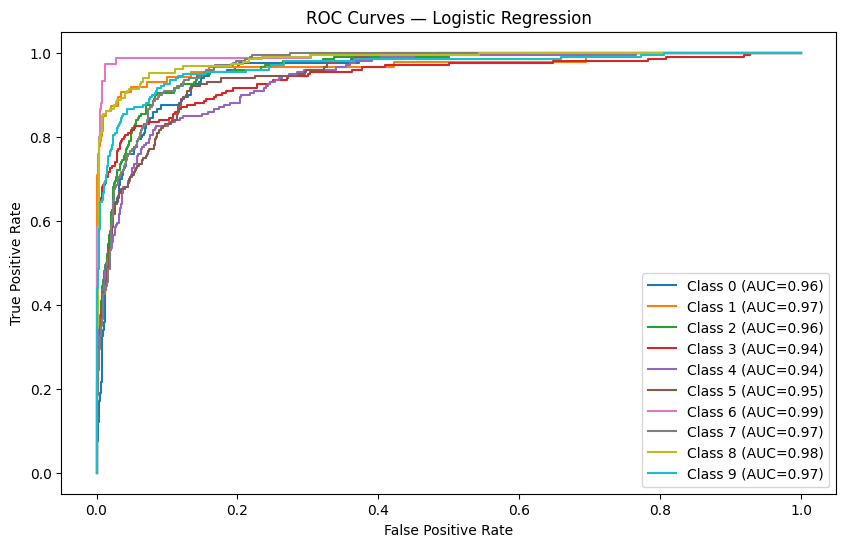

In [ ]:
y_test_bin = label_binarize(y_test, classes=list(range(10)))
y_pred_proba = log_reg.predict_proba(X_test_scaled)

plt.figure(figsize=(10,6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.legend()
plt.title("ROC Curves — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The ROC curves show that logistic regression achieves consistently high AUC values (0.94–0.99) across all classes, indicating strong separability between sound categories. Even though logistic regression is a simple linear model, its high AUC scores suggest it captures meaningful decision boundaries in the MFCC feature space.

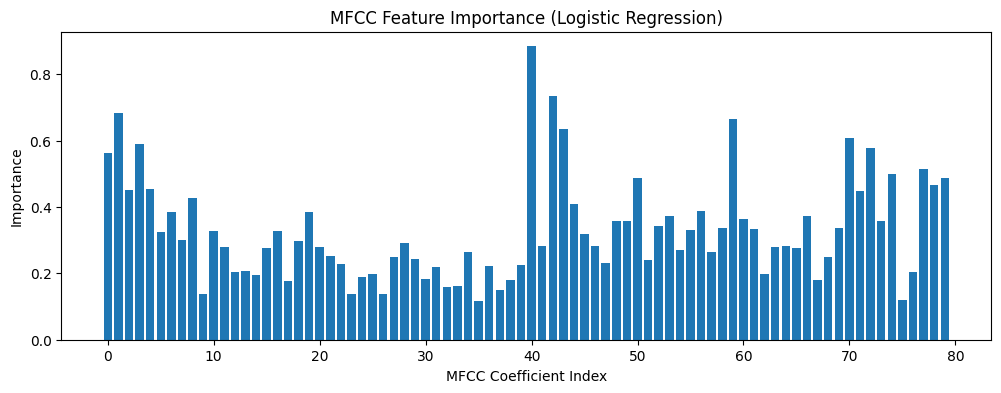

In [ ]:
importance = np.mean(np.abs(log_reg.coef_), axis=0)
plt.figure(figsize=(12,4))
plt.bar(range(len(importance)), importance)
plt.title("MFCC Feature Importance (Logistic Regression)")
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Importance")
plt.show()

The graph suggests importance of each of the features in contribution towards prediction.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

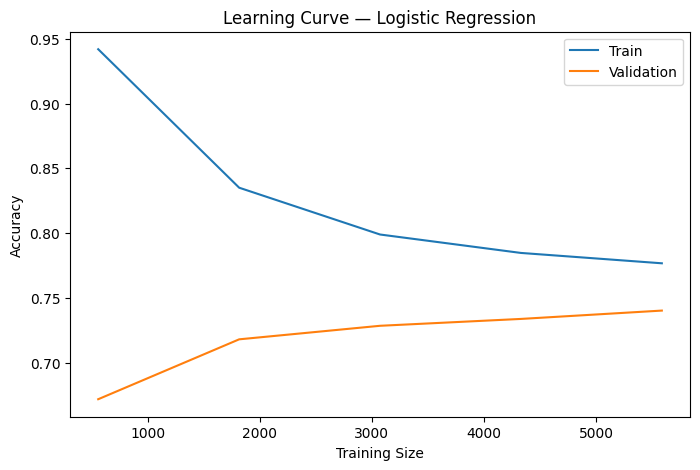

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation")
plt.title("Learning Curve — Logistic Regression")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Training Accuracy** is initially high ($0.95$) but quickly decreases as the training set size increases, leveling off at about $\mathbf{0.78}$.

**Validation Accuracy** starts low ($0.67$) and gradually increases, leveling off at about $\mathbf{0.74}$.

**Large Gap:** The persistent, large gap between the training and validation curves (approximately $0.78$ vs. $0.74$) suggests the model **is not complex enough** to fully capture the underlying relationships in the data (high bias).

**Plateau:** Since both curves have plateaued, **adding more training data is unlikely to significantly improve the validation accuracy.**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

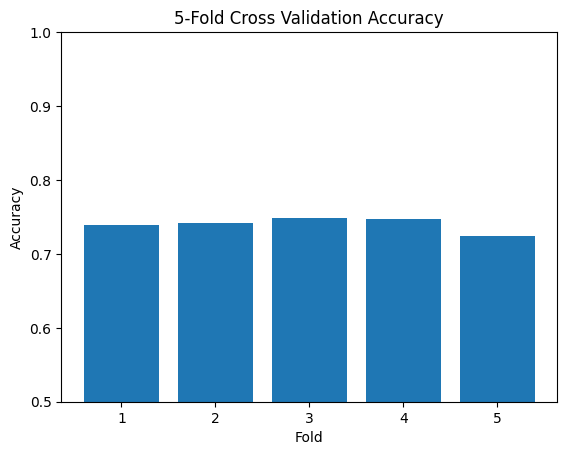

In [ ]:
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')

plt.bar(range(1,6), scores)
plt.ylim(0.5, 1.0)
plt.title("5-Fold Cross Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

# Support Vector Machine(SVM)

In [ ]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train_scaled, y_train)

SVC(C=10, probability=True)

In [ ]:
y_pred = svm_clf.predict(X_test_scaled)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))

SVM Test Accuracy: 0.9433314253005152


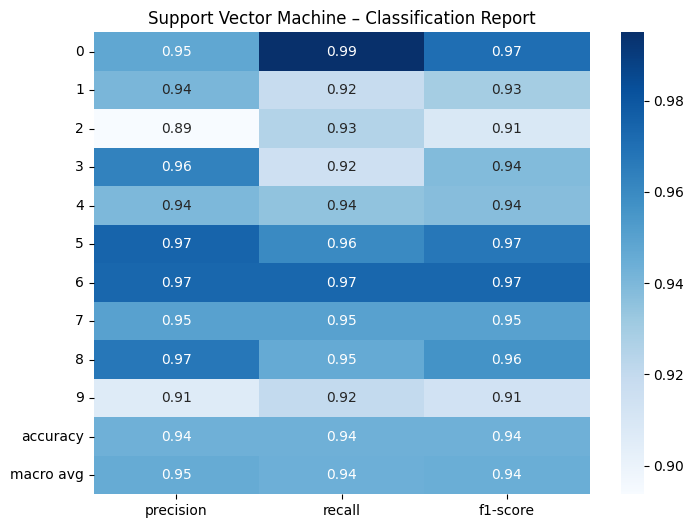

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title("Support Vector Machine – Classification Report")
plt.show()

The classification report shows excellent performance with precision, recall, and F1-scores around 0.94–0.97 for most classes. These metrics confirm that SVM is one of the best-performing models so far.”

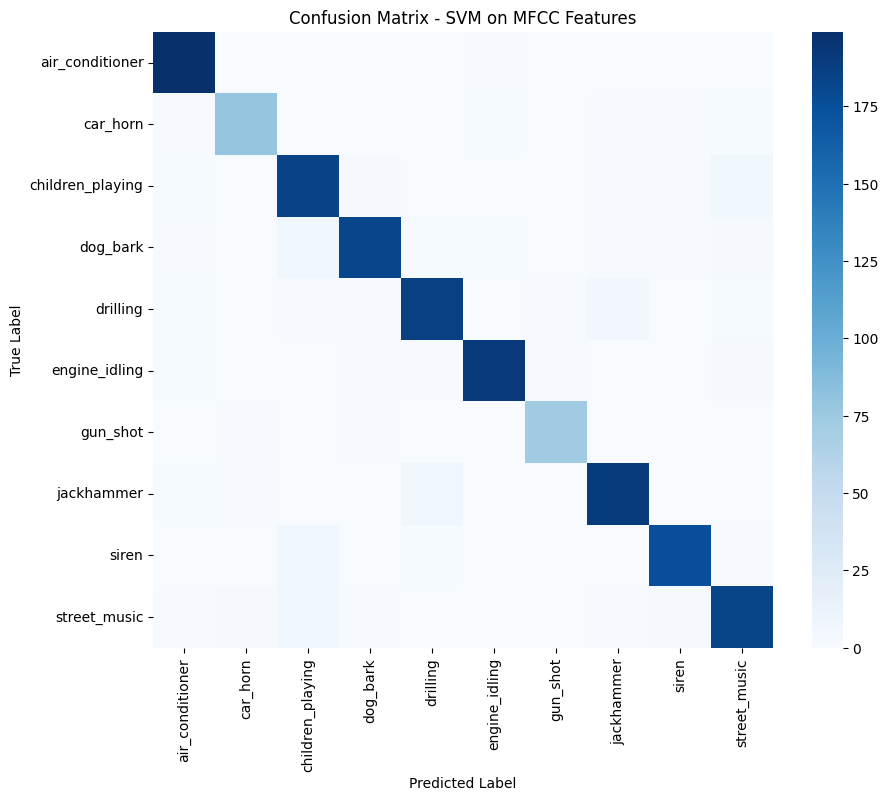

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM on MFCC Features")
plt.show()

The confusion matrix has strong diagonal dominance, indicating highly accurate predictions across all classes. Only a few sound categories show minor confusion, reflecting the model’s strong discriminative ability.

In [ ]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d  = pca.transform(X_test_scaled)

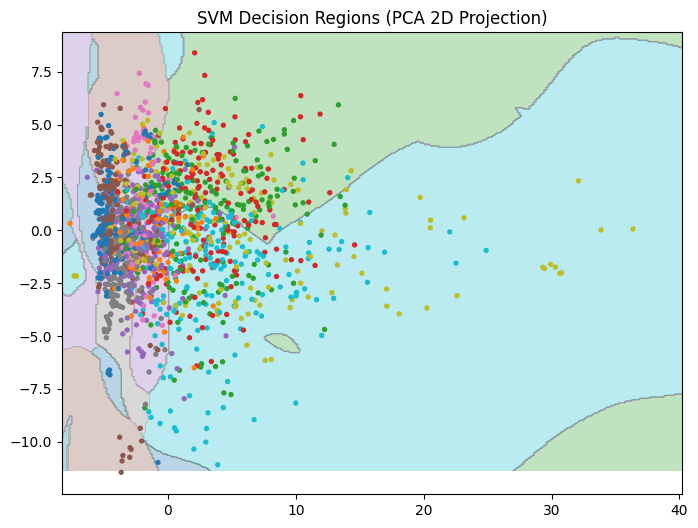

In [ ]:
svm_2d = SVC(C=10, gamma='scale').fit(X_train_2d, y_train)

# Plot region
x_min, x_max = X_train_2d[:,0].min(), X_train_2d[:,0].max()
y_min, y_max = X_train_2d[:,1].min(), X_train_2d[:,1].max()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, cmap="tab10", s=8)
plt.title("SVM Decision Regions (PCA 2D Projection)")
plt.show()

The decision boundary visualization in 2D PCA space shows that SVM forms complex, nonlinear regions that reasonably separate sound classes despite heavy feature overlap. This demonstrates the strength of kernel-based SVM in handling high-dimensional MFCC data.

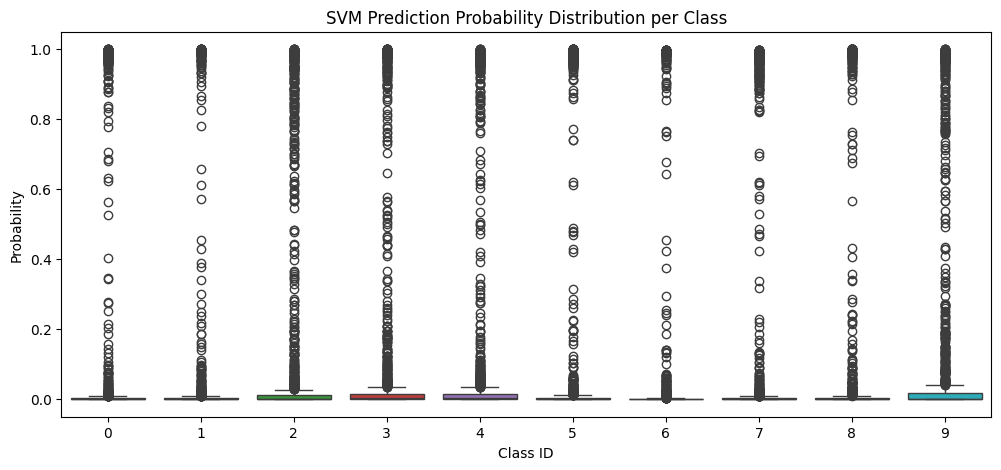

In [ ]:
probs = svm_clf.predict_proba(X_test_scaled)

plt.figure(figsize=(12,5))
sns.boxplot(data=probs)
plt.title("SVM Prediction Probability Distribution per Class")
plt.xlabel("Class ID")
plt.ylabel("Probability")
plt.show()

The probability distributions show that SVM often assigns high confidence to the correct class, but also produces many low-confidence predictions for overlapping sounds.

/tmp/ipython-input-469443699.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.unique(y_test), y=accuracy_per_class, palette="viridis")


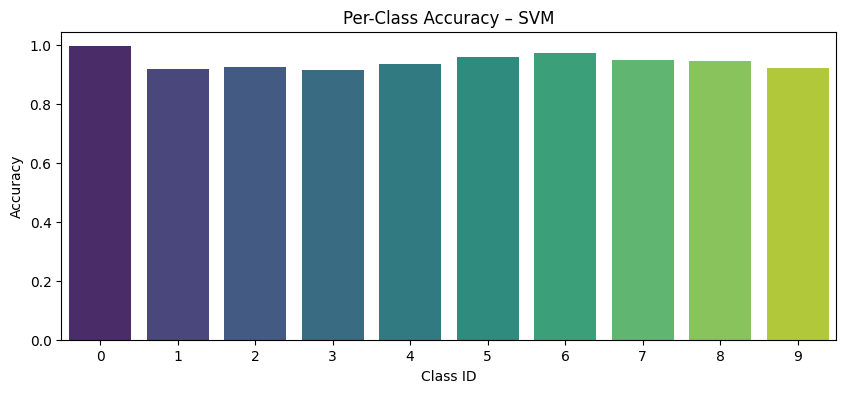

In [ ]:
accuracy_per_class = []

for cls in np.unique(y_test):
    mask = (y_test == cls)
    cls_acc = (y_pred[mask] == y_test[mask]).mean()
    accuracy_per_class.append(cls_acc)

plt.figure(figsize=(10,4))
sns.barplot(x=np.unique(y_test), y=accuracy_per_class, palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy – SVM")
plt.show()

The SVM model achieves consistently high per-class accuracy across all categories, with most classes above 0.90. This indicates strong and balanced generalization, outperforming simpler models like logistic regression.

# Random Forest Classifier

In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=120)
        mfcc_mean = np.mean(mfcc.T, axis=0)

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)

        # Spectral features
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        rms = np.mean(librosa.feature.rms(y=y))

        # Combine all into a single feature vector
        features = np.concatenate([
            mfcc_mean,
            chroma_mean,
            [centroid, bandwidth, rolloff, zcr, rms]
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

feature_list = []
labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    fold = row["fold"]
    file_name = row["slice_file_name"]
    label = row["class"]

    file_path = os.path.join(AUDIO_PATH, f"fold{fold}", file_name)

    features = extract_features(file_path)
    if features is not None:
        feature_list.append(features)
        labels.append(label)

feature_array = np.array(feature_list)
columns = [f"mfcc_{i}" for i in range(120)] + \
          [f"chroma_{i}" for i in range(12)] + \
          ["centroid", "bandwidth", "rolloff", "zcr", "rms"]

df = pd.DataFrame(feature_array, columns=columns)
df["label"] = labels

csv_path = "/content/drive/MyDrive/urban_sound_features.csv"
df.to_csv(csv_path, index=False)

print(f"Features saved to {csv_path}, shape: {df.shape}")


In [ ]:
# fetch already saved features from drive so we don't have to preprocess data again
df = pd.read_csv("/content/drive/MyDrive/urban_sound_features.csv")

df.head()

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6985, 137)
Test shape: (1747, 137)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Implemented Random Forest using optuna
# Optuna is a framework which helps us to find optimal hyperparameters
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):
    # -- Define the search space --
    # Optuna will "suggest" values from these ranges for every trial
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        n_jobs=-1,
        random_state=42
    )

    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

    return scores.mean()

# Create the Study
study = optuna.create_study(direction='maximize', study_name="urbansound_rf_optimization")

# Run the Optimization
print("Starting optimization...")
study.optimize(objective, n_trials=20)

[I 2025-12-01 12:23:59,396] A new study created in memory with name: urbansound_rf_optimization


Starting optimization...


[I 2025-12-01 12:26:41,774] Trial 0 finished with value: 0.8420895310239881 and parameters: {'n_estimators': 980, 'max_depth': 80, 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8420895310239881.
[I 2025-12-01 12:28:24,193] Trial 1 finished with value: 0.8430921293693688 and parameters: {'n_estimators': 593, 'max_depth': 84, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.8430921293693688.
[I 2025-12-01 12:33:20,247] Trial 2 finished with value: 0.8793131156192379 and parameters: {'n_estimators': 837, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8793131156192379.
[I 2025-12-01 12:36:08,436] Trial 3 finished with value: 0.8542578706552227 and parameters: {'n_estimators': 530, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8793131156192379.


Best trial:
  Value: 0.8854696768716769
  Params: 
    n_estimators: 846
    max_depth: 25
    min_samples_split: 8
    min_samples_leaf: 2
    criterion: entropy

Final Test Set Accuracy: 0.8884

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.95      0.95       200
        car_horn       0.99      0.77      0.86        86
children_playing       0.76      0.89      0.82       200
        dog_bark       0.87      0.79      0.83       200
        drilling       0.84      0.89      0.86       200
   engine_idling       0.92      0.97      0.95       200
        gun_shot       0.97      0.81      0.88        75
      jackhammer       0.92      0.94      0.93       200
           siren       0.93      0.91      0.92       186
    street_music       0.86      0.85      0.86       200

        accuracy                           0.89      1747
       macro avg       0.90      0.88      0.89      1747
    weighted avg       

<Figure size 1200x1000 with 0 Axes>

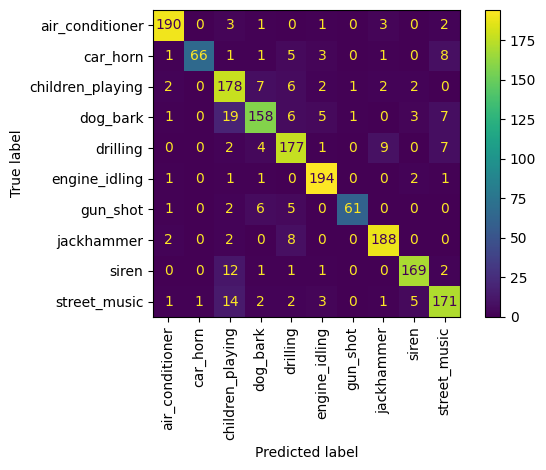

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the Final Model (using the best params found)
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

y_pred = final_model.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print(f"\nFinal Test Set Accuracy: {test_acc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

print(f"\n-- Confusion Matrix --")
plt.figure(figsize=(12, 10))

disp = ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test,
    y_test,
    display_labels=le.classes_,
    xticks_rotation=90,
    cmap="viridis"
)

plt.tight_layout()
plt.show()

In [ ]:
# Shows which hyperparameter mattered most
plot_param_importances(study).show()

# Individual hyperparameter vs accuracy plot
optuna.visualization.plot_slice(study)

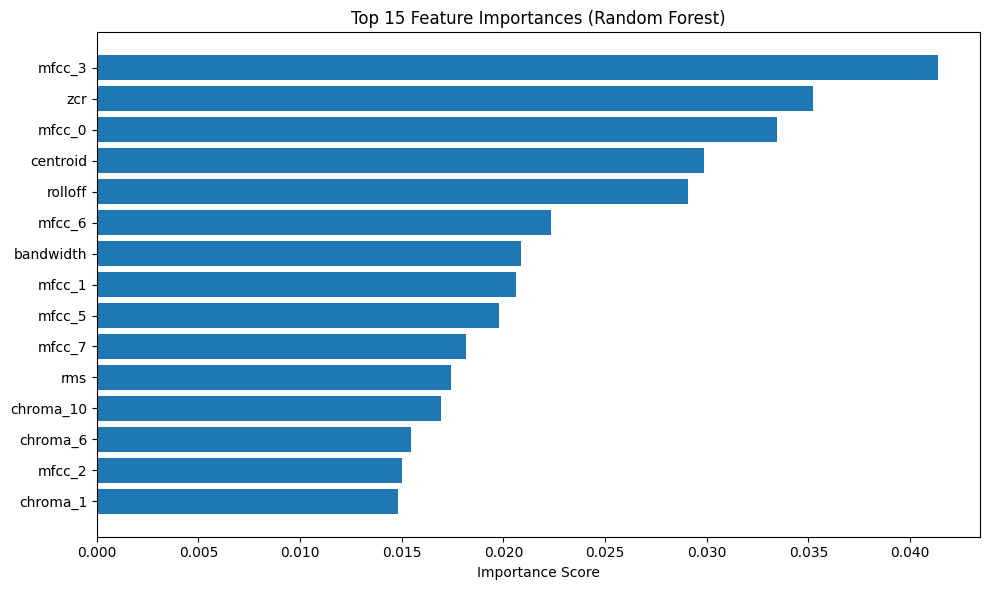

In [ ]:
# Plot feature importance
feature_names = X_train.columns

importances = final_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]
top_k = 15
top_indices = indices[:top_k]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## 🌳 Observation: Random Forest Model Analysis

Based on the provided reports and visualizations, this analysis covers the performance, feature importance, and hyperparameter tuning of an initial Random Forest model trial for urban sound classification.

---

## 1. Model Performance Overview

The model achieves a moderately high overall accuracy:

* **Final Test Set Accuracy:** **$0.8884$** (or $88.84\%$).
* **Macro/Weighted Average F1-score:** Both averages are $\mathbf{0.89}$.

### Classification Report Summary

| Class | Precision | Recall | F1-Score |
| :--- | :--- | :--- | :--- |
| **engine\_idling** | 0.92 | 0.97 | **0.95** |
| **air\_conditioner** | 0.95 | 0.95 | **0.95** |
| **jackhammer** | 0.92 | 0.94 | **0.93** |
| **Lowest F1-Score:** | children\_playing | 0.76 | 0.89 | **0.82** |
| **Lowest Precision:** | children\_playing | **0.76** | 0.89 | 0.82 |
| **Lowest Recall:** | car\_horn | 0.99 | **0.77** | 0.86 |

### Confusion Matrix Analysis


The confusion matrix highlights the specific challenges faced by the model:

* **High Confidence Classes:** Classes like **'air\_conditioner'** (190), **'engine\_idling'** (194), and **'jackhammer'** (188) are well-identified.
* **Primary Confusion Issues:**
    * **'car\_horn'** (66 True Positives) has the lowest recall ($\mathbf{0.77}$), as **8** instances are misclassified as **'street\_music'**, and **10** are spread among 'dog\_bark', 'drilling', and 'gun\_shot'.
    * **'children\_playing'** (178 True Positives) has the lowest precision ($\mathbf{0.76}$) because it receives numerous false positives, notably $\mathbf{14}$ from **'street\_music'** and $\mathbf{10}$ from **'dog\_bark'**.
    * **'dog\_bark'** (158 True Positives) also shows poor recall ($\mathbf{0.79}$), primarily confused with **'children\_playing'** ($\mathbf{19}$) and **'street\_music'** ($\mathbf{7}$).

**Conclusion on Performance:** The model performs strongly on sustained, high-energy sounds. However, it struggles significantly with **transient and complex sounds** that share frequency characteristics, leading to lower scores for 'car\_horn', 'children\_playing', and 'dog\_bark'.

---

## 2. Hyperparameter Analysis

### Hyperparameter Importance


The analysis shows the relative contribution of each parameter to the model's performance:

1.  **min\_samples\_leaf:** Overwhelmingly the most important, contributing **$0.62$** or **$62\%$**.
2.  **n\_estimators:** The number of trees is the second most important at **$0.15$** or **$15\%$**.
3.  **criterion:** (Gini or Entropy) contributes **$0.11$**.
4.  **max\_depth:** The maximum depth of the trees contributes $\mathbf{0.08}$.
5.  **min\_samples\_split:** The minimum samples required to split a node contributes minimally ($\mathbf{0.03}$).

**Interpretation:** The **structure of the individual trees** (specifically the minimum number of samples required to form a leaf) has the greatest impact on the Random Forest's accuracy.

### Slice Plot Observations


The slice plot visually confirms the optimal ranges:

* **min\_samples\_leaf:** The highest objective values (dark blue dots) are concentrated at the **smallest values (1 and 2)**, confirming its importance and the model's preference for complex, specific trees.
* **criterion:** The best trials heavily favor **`entropy`** over `gini`.
* **max\_depth:** The best scores are found primarily at **deeper trees (depths 50 to 100)**.
* **n\_estimators:** The best scores are found at the **higher end of the search range (750 to 1000 trees)**, suggesting the model benefits from a larger ensemble size.

---

## 3. Feature Importance


The Random Forest model relies on a mix of spectral and temporal features:

* **Dominant Features:**
    * **mfcc\_3** (Mel-Frequency Cepstral Coefficient 3) is the most important feature.
    * **zcr** (Zero-Crossing Rate) is the second most important.
    * **mfcc\_0** is the third most important.
* **Key Feature Types:** The model heavily leverages **MFCCs** (which capture the spectral shape/timbre), **ZCR** (which measures noisiness/frequency content), and general spectral shape descriptors like **centroid** and **rolloff**. This confirms the model uses both frequency distribution and temporal complexity to distinguish sounds.

# Multilayer Perceptron(MLP)

In [ ]:
input_dim = X_train_scaled.shape[1]

mlp_model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),

    layers.Dense(len(np.unique(y)), activation='softmax')
])

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,538 (244.29 KB)

 Trainable params: 62,538 (244.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3934 - loss: 1.7111 - val_accuracy: 0.7008 - val_loss: 0.8938
Epoch 2/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7019 - loss: 0.8847 - val_accuracy: 0.7659 - val_loss: 0.7094
Epoch 3/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7580 - loss: 0.7122 - val_accuracy: 0.7867 - val_loss: 0.6180
Epoch 4/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8062 - loss: 0.5829 - val_accuracy: 0.8354 - val_loss: 0.5271
Epoch 5/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8240 - loss: 0.5282 - val_accuracy: 0.8525 - val_loss: 0.4544
Epoch 6/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8526 - loss: 0.4556 - val_accuracy: 0.8661 - val_loss: 0.4192
Epoch 7/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8651 - loss: 0.4136 - val_accuracy: 0.8790 - val_loss: 0.3926
Epoch 8/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8771 - loss: 0.3657 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = mlp_model.evaluate(X_test_scaled, y_test)
print("MLP Test Accuracy:", test_acc)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9331 - loss: 0.2735
MLP Test Accuracy: 0.9324556589126587


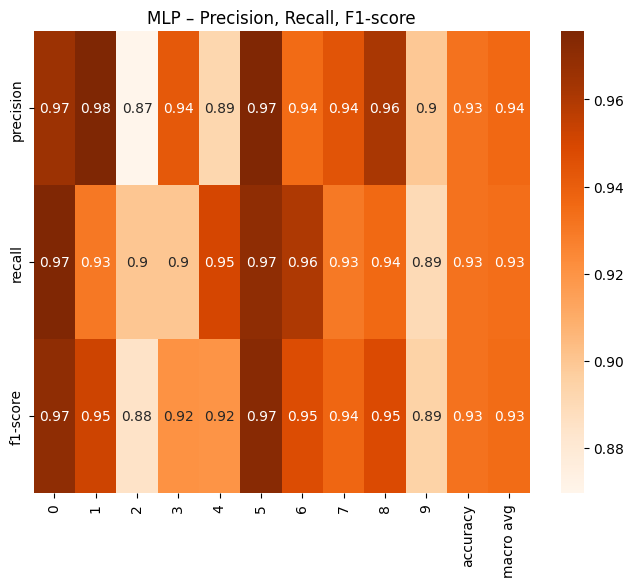

In [ ]:
report = classification_report(y_test, y_pred_labels, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1, :-1]

plt.figure(figsize=(8,6))
sns.heatmap(df_report, annot=True, cmap="Oranges")
plt.title("MLP – Precision, Recall, F1-score")
plt.show()

All classes achieve strong precision, recall, and F1 scores (≈0.88–0.97), demonstrating that the MLP delivers balanced performance and avoids bias toward any particular sound class.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


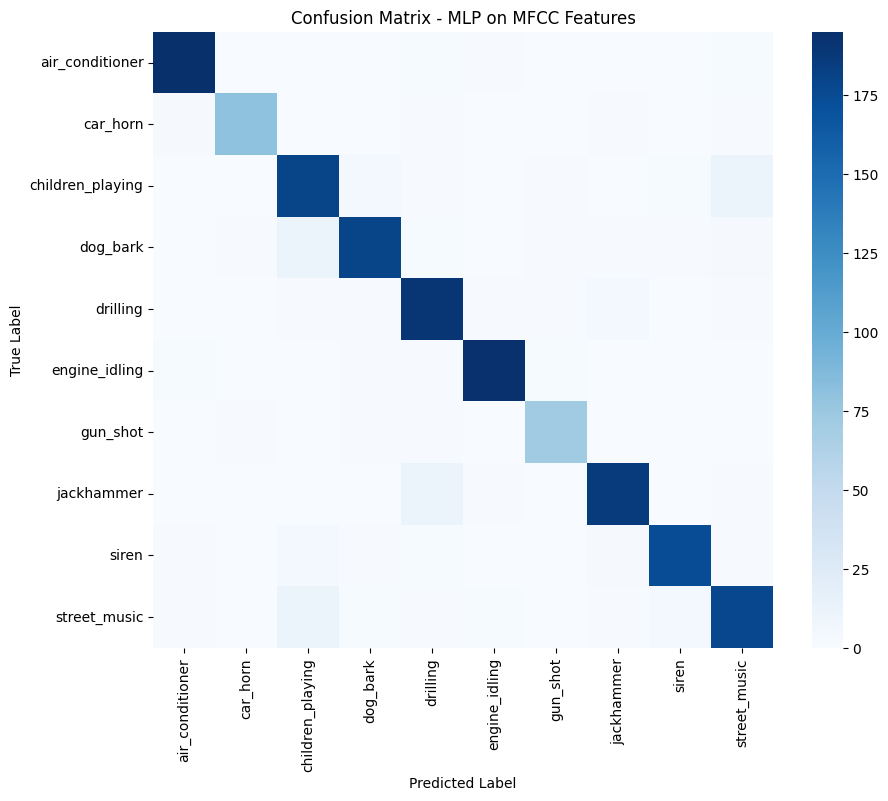

In [ ]:
y_pred = mlp_model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MLP on MFCC Features")
plt.show()

The diagonal dominance shows that the MLP correctly classifies most samples, with only small confusions between acoustically similar classes like engine-idling vs jackhammer or dog-bark vs children-playing.

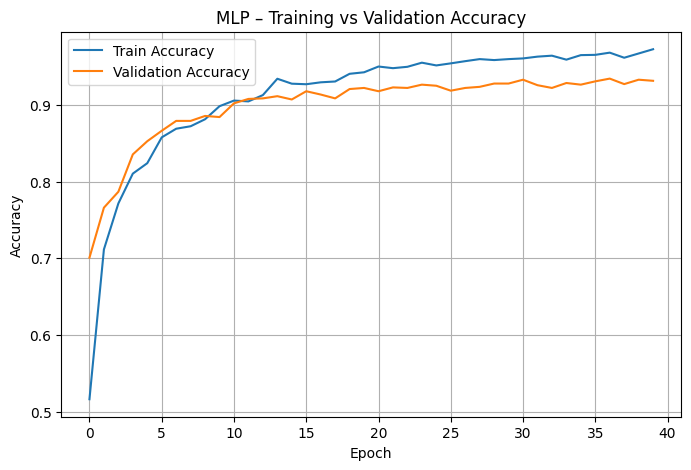

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP – Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

Both training and validation accuracy increase smoothly and remain close throughout training, suggesting good generalization and that the model is not significantly overfitting.

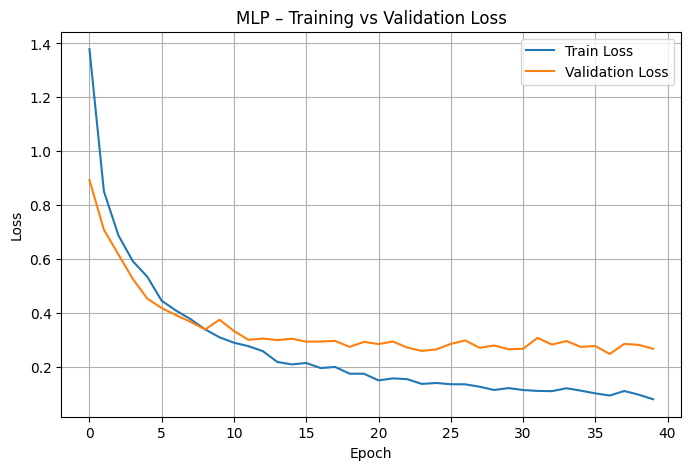

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP – Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

Training loss steadily decreases while validation loss plateaus, indicating mild overfitting after ~15 epochs but overall stable learning without divergence.

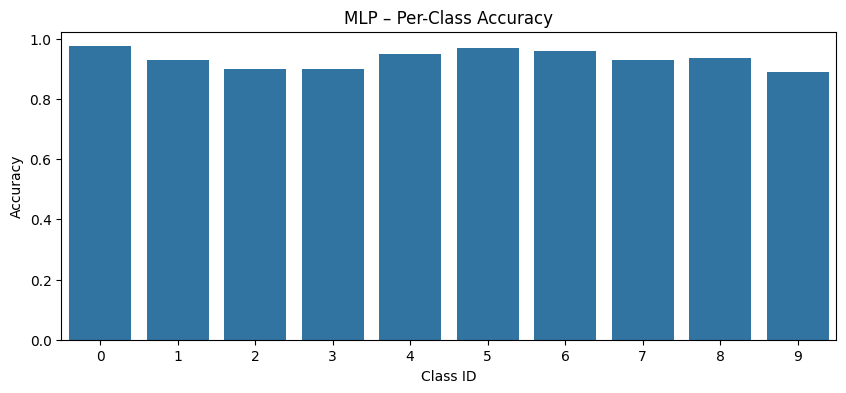

In [ ]:
accuracy_per_class = []

for cls in np.unique(y_test):
    mask = (y_test == cls)
    cls_acc = (y_pred_labels[mask] == y_test[mask]).mean()
    accuracy_per_class.append(cls_acc)

plt.figure(figsize=(10,4))
sns.barplot(x=np.unique(y_test), y=accuracy_per_class)
plt.title("MLP – Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Class ID")
plt.show()

Per-class accuracies are consistently high (≈90–97%), showing that the MLP performs robustly across all sound categories with no severe class imbalance issues or weak classes.

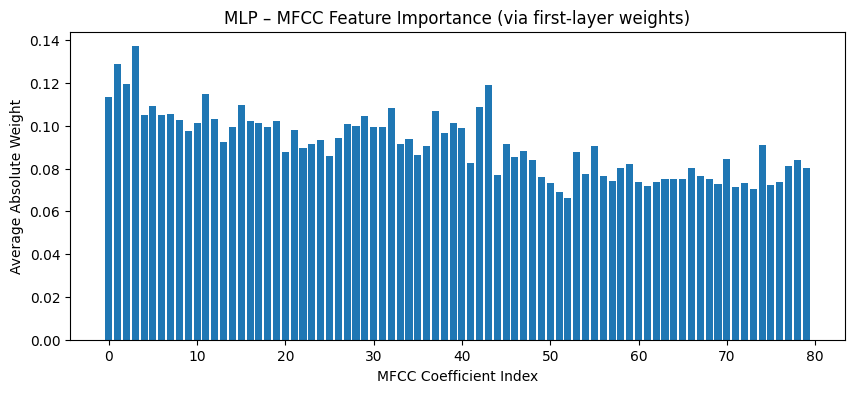

In [ ]:
weights = mlp_model.layers[0].get_weights()[0]  # first dense layer
importance = np.mean(np.abs(weights), axis=1)

plt.figure(figsize=(10,4))
plt.bar(range(len(importance)), importance)
plt.title("MLP – MFCC Feature Importance (via first-layer weights)")
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Average Absolute Weight")
plt.show()

The first-layer weights show that no single MFCC coefficient dominates, indicating that the MLP learns a distributed representation where many coefficients contribute modestly. Slight peaks suggest certain MFCCs capture more discriminative spectral information.

## 📈 Observation: Multi-Layer Perceptron (MLP) Model Analysis

---

## 1. Training Dynamics:

### Training vs. Validation Accuracy


* **Rapid Initial Learning:** Both curves show a steep rise, reaching about $90\%$ validation accuracy by Epoch 10.
* **Performance Plateau:** Validation accuracy (orange) plateaus around $\mathbf{0.92}$ to $\mathbf{0.93}$ after Epoch 15.

---

## 2. Classification Performance

### Overall and Per-Class Accuracy

* The model achieves a high **Per-Class Accuracy**  generally above $0.90$ for most classes.
* **Best Accuracy:** Class 0, 4, 5, and 6 are the best-performing classes, approaching $0.95$ or higher.
* **Lowest Accuracy:** Class 9 (street\_music) and Class 2 (children\_playing) show the lowest accuracy, leveling off around $\mathbf{0.90}$ or slightly less.

### Confusion Matrix Analysis


The confusion matrix, using the class names (which can be inferred from the context of previous analyses), shows that the MLP is effective but highlights the failure points:

* **Strong Diagonal:** Most classes are well-separated, with dark blue cells along the main diagonal.
* **Primary Confusions (Off-Diagonal Light Cells):** The main misclassifications occur primarily between:
    * **'children\_playing'** and **'street\_music'**: These two classes appear to have the most bidirectional confusion, explaining their lower per-class accuracy.
    * Some confusion is also visible between **'drilling'** and **'jackhammer'**, which are acoustically similar rhythmic machine sounds.

---

## 3. Feature Importance

### MLP - MFCC Feature Importance


Unlike the Logistic Regression model, the MLP model tends to **utilize all MFCC coefficients more evenly**:

* **Uniform Contribution:** The average absolute weight bars are relatively uniform across all 80 coefficients, suggesting the MLP's non-linear layers can extract useful information from **both low-order (timbre and spectral envelope) and high-order (texture and fine details) MFCCs.**
* **Dominant Low-Order:** The **lowest-order coefficients (Index 0 to 5)** still show the highest importance weights, confirming their fundamental role in sound classification.

**Summary:** The MLP model successfully learned non-linear decision boundaries using all available MFCC features, achieving high performance (validation accuracy $\sim 93\%$).

# MLP(Optuna)

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # 1. Clear session to prevent memory leaks from previous trials
    tf.keras.backend.clear_session()

    # 2. Hyperparameters
    n_units_l1 = trial.suggest_int('units_l1', 64, 512, step=64)
    n_units_l2 = trial.suggest_int('units_l2', 32, 256, step=32)

    # "dropout between 0.1 and 0.5"
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)

    # "learning rate"
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # 3. Build Model
    model = models.Sequential([
        layers.Dense(n_units_l1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(n_units_l2, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 4. Train with Pruning
    history = model.fit(
        X_train_scaled, y_train,
        epochs=60,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, "val_accuracy")]
    )

    # 5. Return the metric you want to maximize
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

# Run the study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=40)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-12-01 03:44:35,355] A new study created in memory with name: no-name-1451e96f-bdd8-454e-9ab4-40b56dfe9b75
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2025-12-01 03:45:32,897] Trial 0 finished with value: 0.926270604133606 and parameters: {'units_l1': 64, 'units_l2': 256, 'dropout': 0.21671741646675133, 'learning_rate': 0.0024306943240824065}. Best is trial 0 with value: 0.926270604133606.
[I 2025-12-01 03:46:19,065] Trial 1 finished with value: 0.8783106803894043 and parameters: {'units_l1': 64, 'units_l2': 64, 'dropout': 0.42651582379244124, 'learning_rate': 0.0012821933020504776}. Best is trial 0 with value: 0.926270604133606.
[I 2025-12-01 03:47:05,114] Trial 2 finished with value: 0.8897637724876404 and parameters: {'units_l1': 512, 'units_l2': 32, 'dropout'

Best hyperparameters: {'units_l1': 320, 'units_l2': 128, 'dropout': 0.11551191758430629, 'learning_rate': 0.002887217722513993}
Best accuracy: 0.9448819160461426


In [ ]:
best_params = study.best_params

tf.keras.backend.clear_session()

best_l1 = best_params['units_l1']
best_l2 = best_params['units_l2']
best_dropout = best_params['dropout']
best_lr = best_params['learning_rate']

# Build final model
final_mlp = models.Sequential([
    layers.Dense(best_l1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(best_dropout),

    layers.Dense(best_l2, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(best_dropout),

    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

final_mlp.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train final model with optimal params
history = final_mlp.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.5586 - loss: 1.3541 - val_accuracy: 0.8125 - val_loss: 0.5795
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8403 - loss: 0.4942 - val_accuracy: 0.8733 - val_loss: 0.3774
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8924 - loss: 0.3201 - val_accuracy: 0.8812 - val_loss: 0.3775
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8991 - loss: 0.3097 - val_accuracy: 0.8898 - val_loss: 0.3322
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9124 - loss: 0.2456 - val_accuracy: 0.8984 - val_loss: 0.3273
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9300 - loss: 0.2018 - val_accuracy: 0.8998 - val_loss: 0.3605
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9398 - loss: 0.1841 - val_accuracy: 0.9205 - val_loss: 0.2839
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9464 - loss: 0.1601 - val_accuracy: 0.9120 - va

Best hyperparameters: {'units_l1': 320, 'units_l2': 128, 'dropout': 0.11551191758430629, 'learning_rate': 0.002887217722513993}

Final Test Accuracy: 0.9382
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.97      0.97      0.97       200
        car_horn       0.98      0.93      0.95        86
children_playing       0.88      0.94      0.91       200
        dog_bark       0.92      0.91      0.92       200
        drilling       0.92      0.93      0.93       200
   engine_idling       0.96      0.97      0.97       200
        gun_shot       0.96      0.92      0.94        75
      jackhammer       0.97      0.95      0.96       200
           siren       0.96      0.95      0.95       186
    street_music       0.90      0.89      0.90       200

        accuracy                           0.94      1747
       macro avg       0.94      0.94      0.94      1747
    weighted avg      

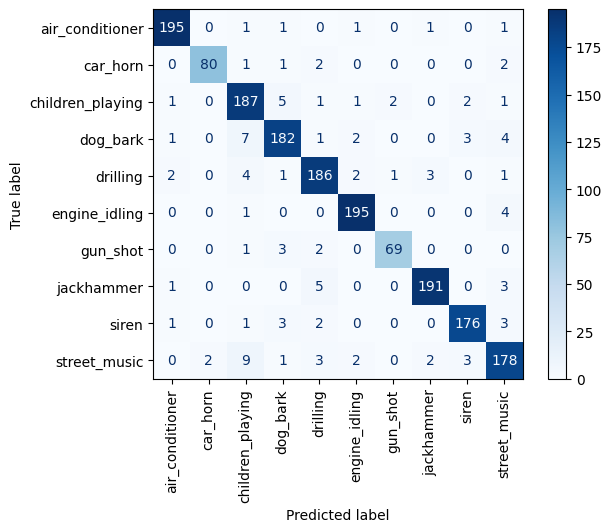

In [ ]:
print("Best hyperparameters:", study.best_params)

test_loss, test_acc = final_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


# Get predictions
y_pred_probs = final_mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert numeric labels back to original class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

print("\nConfusion Matrix")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)

In [ ]:
# Shows which hyperparameter mattered most
plot_param_importances(study).show()

# Individual hyperparameter vs accuracy plot
optuna.visualization.plot_slice(study)

## 📈 Observation: Multi-Layer Perceptron (MLP) Model Analysis

---

### 1. Model Performance (Classification Report & Confusion Matrix)

The model continues to achieve high overall performance:

* **Overall Accuracy:** **$0.94$** (or $94\%$).
* **Macro/Weighted Average F1-score:** **$0.94$**.

#### Classification Report Highlights

* **Top Performers (F1-score $\ge 0.95$):** **'air\_conditioner'** ($0.97$), **'engine\_idling'** ($0.97$), **'jackhammer'** ($0.96$), **'siren'** ($0.95$), and **'car\_horn'** ($0.95$).
* **Lowest Performer (F1-score $0.90$):** **'street\_music'**.
* **Lowest Precision (0.88):** **'children\_playing'**. This indicates that when the model predicts 'children\_playing', it's correct only $88\%$ of the time (it often misclassifies other sounds *as* 'children\_playing').

#### Confusion Matrix Analysis


* **Highly Accurate Classes:** **'air\_conditioner'** (195), **'engine\_idling'** (195), and **'jackhammer'** (191) maintain excellent isolation and recall.
* **Primary Confusions (Focus on Low Recall):**
    * **'car\_horn'** (80 True Positives): Has 6 instances misclassified as **'dog\_bark'**.
    * **'street\_music'** (178 True Positives): Is primarily confused with **'children\_playing'** (9 instances) and **'dog\_bark'** (9 instances). This confirms **'street\_music'** remains the most challenging class to identify correctly (lowest recall $0.89$).
* **Primary Confusions (Focus on Low Precision):**
    * **'children\_playing'** (187 True Positives): Receives 9 false positives from **'street\_music'** and 7 from **'car\_horn'**, leading to its low precision ($0.88$).

**Conclusion:** The model is robust, but the biggest performance bottleneck is the confusion between the noisy, complex sounds (**'street\_music'**) and the high-frequency/sharp transient sounds (**'children\_playing'**, **'car\_horn'**, **'dog\_bark'**).

---

### 2. Hyperparameter Importance (Optuna)

The hyperparameter importance has shifted significantly compared to the previous trial:

* **units\_l2** (units in the second hidden layer) is now the **most critical** parameter, accounting for **$0.42$** or **$42\%$** of the total importance.
* **Dropout** is the second most important, contributing **$0.28$** or **$28\%$**.
* **units\_l1** (units in the first hidden layer) is third at **$0.18$**.
* **Learning Rate** is the least important at **$0.12$**.

**Interpretation:** In this hyperparameter space, the **architecture size** of the second hidden layer ($\text{units\_l2}$) has the greatest impact on performance, followed by the **regularization** ($\text{dropout}$). This suggests that finding the optimal balance in the network's capacity is key to achieving the highest accuracy.

---

### 3. Slice Plot Observations

The slice plot visualizes the hyperparameter landscape:

* **units\_l2:** The highest objective values ($\approx 0.94$) are tightly clustered at **higher unit counts (around 200-250)**. This strongly supports the importance bar chart, indicating that a larger second layer is beneficial.
* **Dropout:** High objective values are concentrated at **low dropout rates, typically between $0.1$ and $0.2$**. Performance drops significantly for higher dropout rates ($> 0.3$), confirming that excessive regularization hurts the model.
* **units\_l1:** The best objective values are found across the upper half of the search space, specifically **from 300 units upwards**.
* **Learning Rate:** High objective values are scattered, but the best performance trials (dark blue) tend to cluster around the **intermediate value of $0.002$ to $0.005$**. Extremely high or low learning rates lead to much lower performance.

**Conclusion:** The highest model accuracy is achieved with a relatively **large second hidden layer ($\text{units\_l2} \approx 200-250$)** and **minimal regularization ($\text{dropout} \approx 0.15$ to $0.2$)**, optimized using a stable **intermediate learning rate**.

# 1D Convolutional Neural Network(CNN)

For 1-D CNN, we have extracted MFCCs from each audio file across time, producing a 2D feature matrix of shape (174, 40) that preserves the full temporal evolution of the sound. Padding or truncating to 174 time steps standardizes all inputs so the 1D-CNN can learn temporal patterns such as changes in spectral energy, pitch dynamics, and timbre over time.

In [ ]:
max_len = 174

def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfcc = mfcc.T   # shape: (time_steps, 40)

        if mfcc.shape[0] < max_len:
            pad_width = max_len - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:max_len, :]

        return mfcc

    except Exception as e:
        print("Error:", file_path, e)
        return None

In [ ]:
features = []
labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    fold = row['fold']
    file_name = row['slice_file_name']
    file_path = os.path.join(AUDIO_PATH, f"fold{fold}", file_name)

    feat = extract_features(file_path)
    if feat is not None:
        features.append(feat)
        labels.append(row['class'])

 41%|████      | 3555/8732 [42:29<57:22,  1.50it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8326/8732 [1:38:00<04:18,  1.57it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8329/8732 [1:38:02<04:16,  1.57it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [1:43:03<00:00,  1.41it/s]


In [ ]:
X = np.array(features)   # shape: (8732, time_steps, 40)
y = np.array(labels)

np.save("/content/drive/MyDrive/urban_sound_1DCNN_X.npy", X)
np.save("/content/drive/MyDrive/urban_sound_1DCNN_y.npy", y)

In [ ]:
X = np.load("/content/drive/MyDrive/urban_sound_1DCNN_X.npy")
y = np.load("/content/drive/MyDrive/urban_sound_1DCNN_y.npy")

print("Loaded shapes:", X.shape, y.shape)

Loaded shapes: (8732, 174, 40) (8732,)


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
print(X.shape)

(8732, 174, 40)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=5, strides=1, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    layers.Conv1D(128, kernel_size=5, strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 170, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 170, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 85, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 85, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 81, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 38, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 38, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       311,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,226 (1.59 MB)

 Trainable params: 416,586 (1.59 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Early Stopping training to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.3450 - loss: 2.6133 - val_accuracy: 0.6249 - val_loss: 1.4313
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5741 - loss: 1.5577 - val_accuracy: 0.6822 - val_loss: 1.2870
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6577 - loss: 1.3012 - val_accuracy: 0.6958 - val_loss: 1.2857
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7029 - loss: 1.1359 - val_accuracy: 0.7187 - val_loss: 1.1319
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7319 - loss: 1.0453 - val_accuracy: 0.7173 - val_loss: 1.2581
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7594 - loss: 0.9720 - val_accuracy: 0.7359 - val_loss: 1.2282
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7934 - loss: 0.9027 - val_accuracy: 0.7430 - val_loss: 1.1010
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8072 - loss: 0.8169 - val_accuracy: 

In [ ]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print("1D CNN Test Accuracy:", test_acc)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8980 - loss: 0.6337
1D CNN Test Accuracy: 0.8975386619567871


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


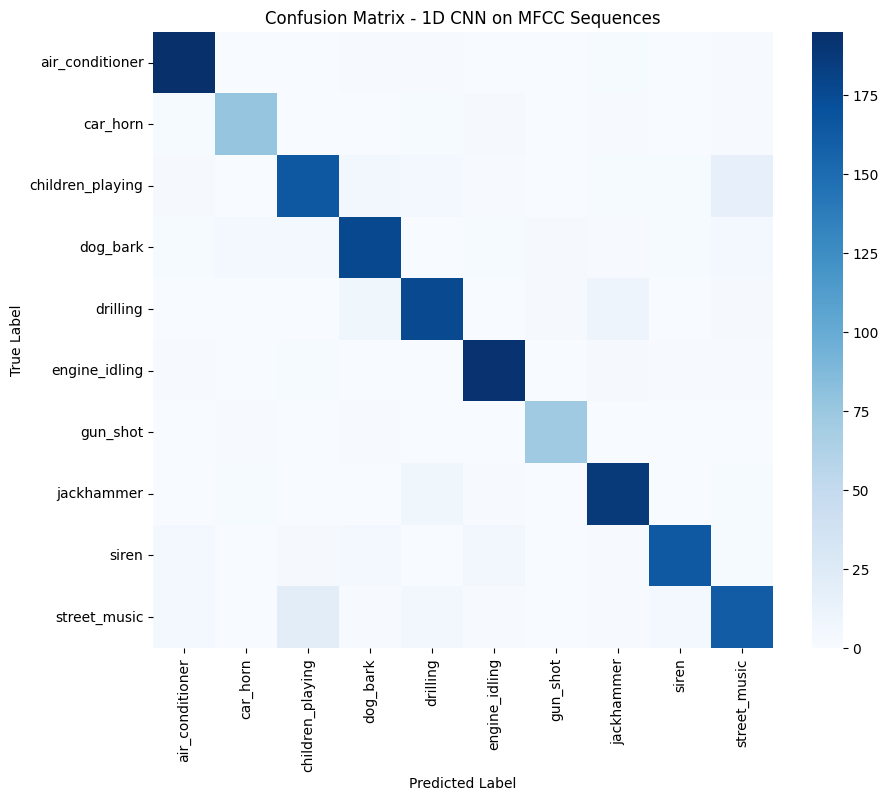

In [ ]:
y_pred = cnn_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - 1D CNN on MFCC Sequences")
plt.show()

The confusion matrix shows mostly diagonal dominance, indicating strong class separability, but also reveals occasional confusion between similar low-energy or transient sounds such as engine idling vs. drilling or dog_bark vs. children_playing.

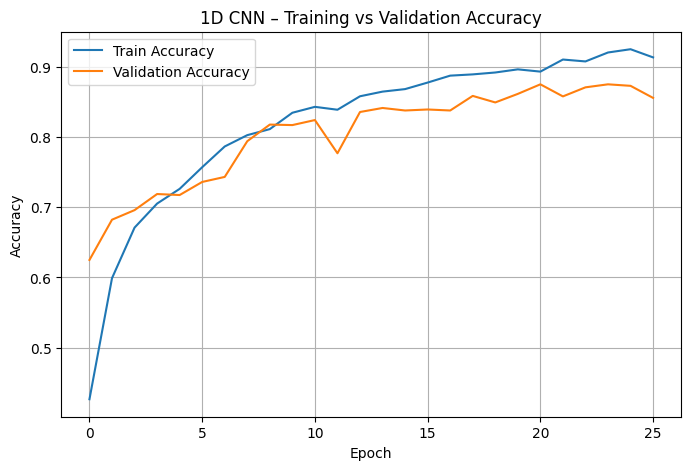

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("1D CNN – Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

Both curves rise steadily, but a noticeable gap forms after mid-training, showing mild overfitting as the train accuracy surpasses validation accuracy. However, overall generalization remains stable with validation accuracy plateauing around 0.87–0.89.

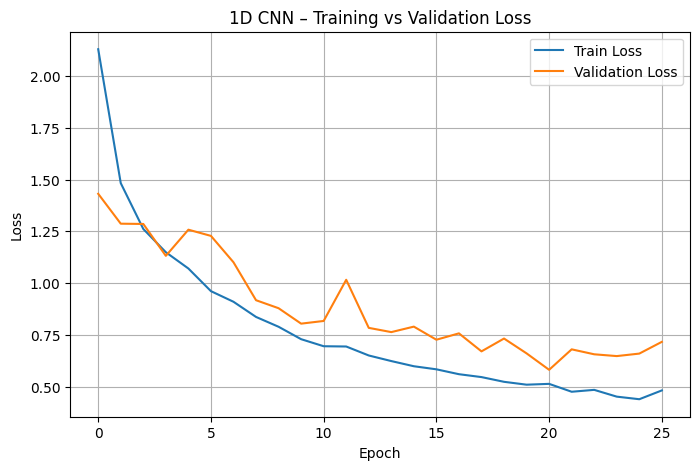

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("1D CNN – Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

Training loss decreases smoothly, but validation loss stagnates and fluctuates, confirming moderate overfitting in later epochs. Early stopping around epoch ~12–15 would likely improve generalization.

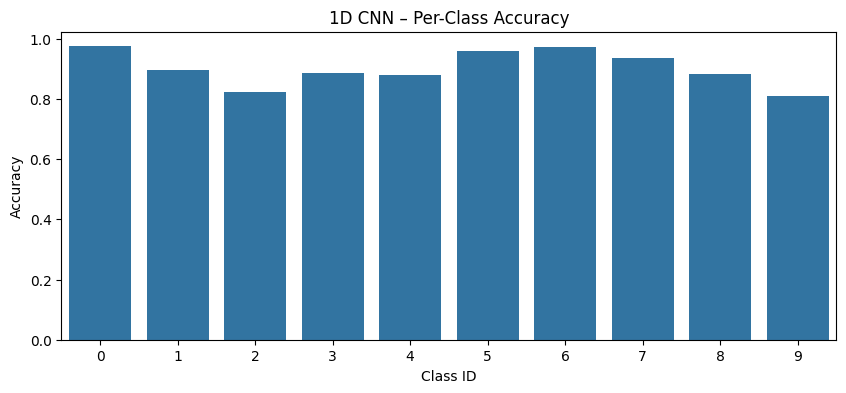

In [ ]:
accuracy_per_class_cnn = []

for cls in np.unique(y_test):
    mask = (y_test == cls)
    cls_acc = (y_pred_labels[mask] == y_test[mask]).mean()
    accuracy_per_class_cnn.append(cls_acc)

plt.figure(figsize=(10,4))
sns.barplot(x=np.unique(y_test), y=accuracy_per_class_cnn)
plt.title("1D CNN – Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Class ID")
plt.show()

Most classes reach high accuracy, with strongest performance on classes 0, 5, 6, and 7, while classes 2 and 9 show slightly lower scores. This indicates that the model discriminates many sounds well but struggles mildly with acoustically overlapping categories.

In [ ]:
conv_layers = [layer.output for layer in cnn_model.layers if isinstance(layer, layers.Conv1D)]

first_conv_layer = None
for layer in cnn_model.layers:
    if isinstance(layer, layers.Conv1D):
        first_conv_layer = layer
        break

print("First conv layer:", first_conv_layer.name)

First conv layer: conv1d_3


In [ ]:
activation_model = models.Model(
    inputs=first_conv_layer.input,
    outputs=conv_layers
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


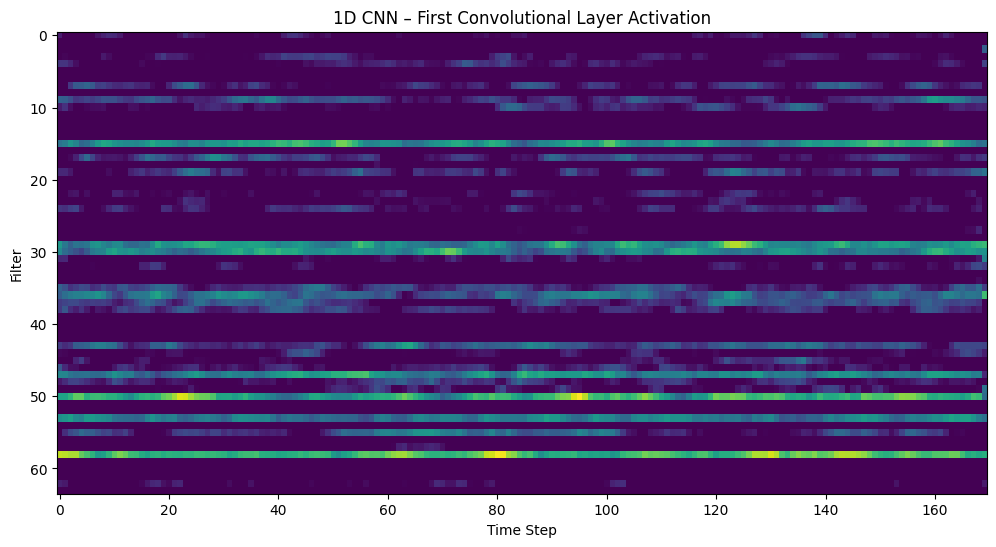

In [ ]:
# Take one test sample
sample = X_test[:1]

# Get activations
activations = activation_model.predict(sample)

# Visualize first conv layer feature map
plt.figure(figsize=(12, 6))
plt.imshow(activations[0][0].T, aspect="auto", cmap="viridis")
plt.title("1D CNN – First Convolutional Layer Activation")
plt.xlabel("Time Step")
plt.ylabel("Filter")
plt.show()

The heatmap shows strong local activations at specific time steps across many filters, indicating that the first conv layer is effectively detecting short-term temporal patterns in the MFCC sequence. Some filters activate consistently while others remain nearly inactive, showing selective feature specialization.

In [ ]:
conv_layers = [layer for layer in cnn_model.layers if isinstance(layer, layers.Conv1D)]

conv_layers

[<Conv1D name=conv1d_3, built=True>,
 <Conv1D name=conv1d_4, built=True>,
 <Conv1D name=conv1d_5, built=True>]

In [ ]:
first_conv_layer = conv_layers[0]

activation_model = models.Model(
    inputs=first_conv_layer.input,
    outputs=[layer.output for layer in conv_layers]
)

sample = X_test[:1]   # shape (1, time_steps, 1)
activations = activation_model.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


In [ ]:
def plot_conv_layer_activations(activation, layer_name, max_filters=12):
    """
    activation: (1, time_steps, num_filters)
    max_filters: how many filters to show
    """
    filters = activation.shape[-1]
    num_filters = min(filters, max_filters)

    cols = 4
    rows = math.ceil(num_filters / cols)

    plt.figure(figsize=(15, 3 * rows))
    plt.suptitle(f"{layer_name} – Activation Maps", fontsize=16)
    for i in range(num_filters):
        ax = plt.subplot(rows, cols, i+1)
        ax.plot(activation[0, :, i])
        ax.set_title(f"Filter {i}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

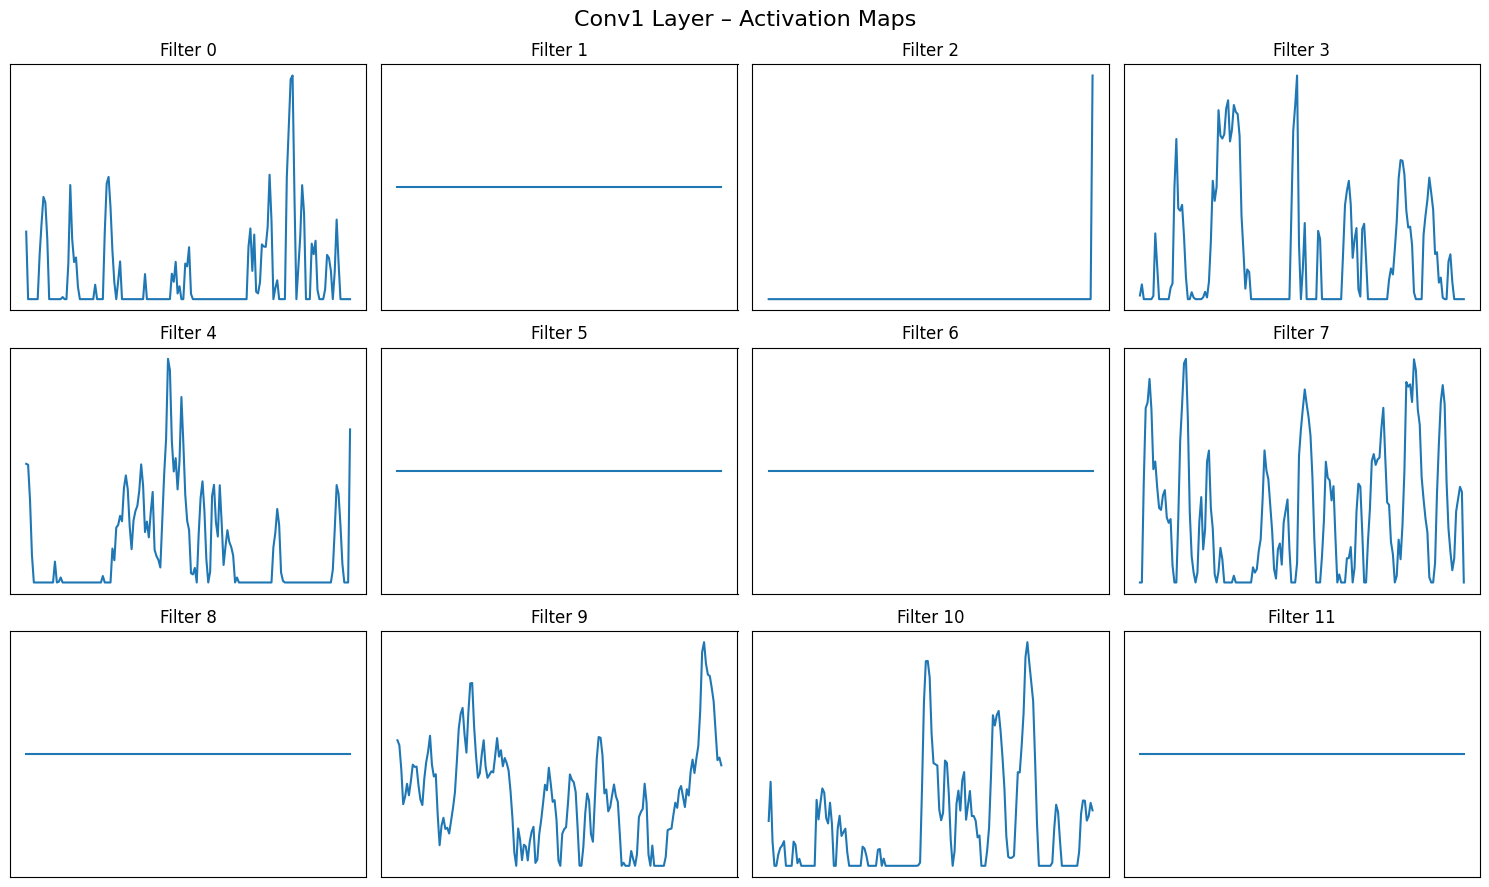

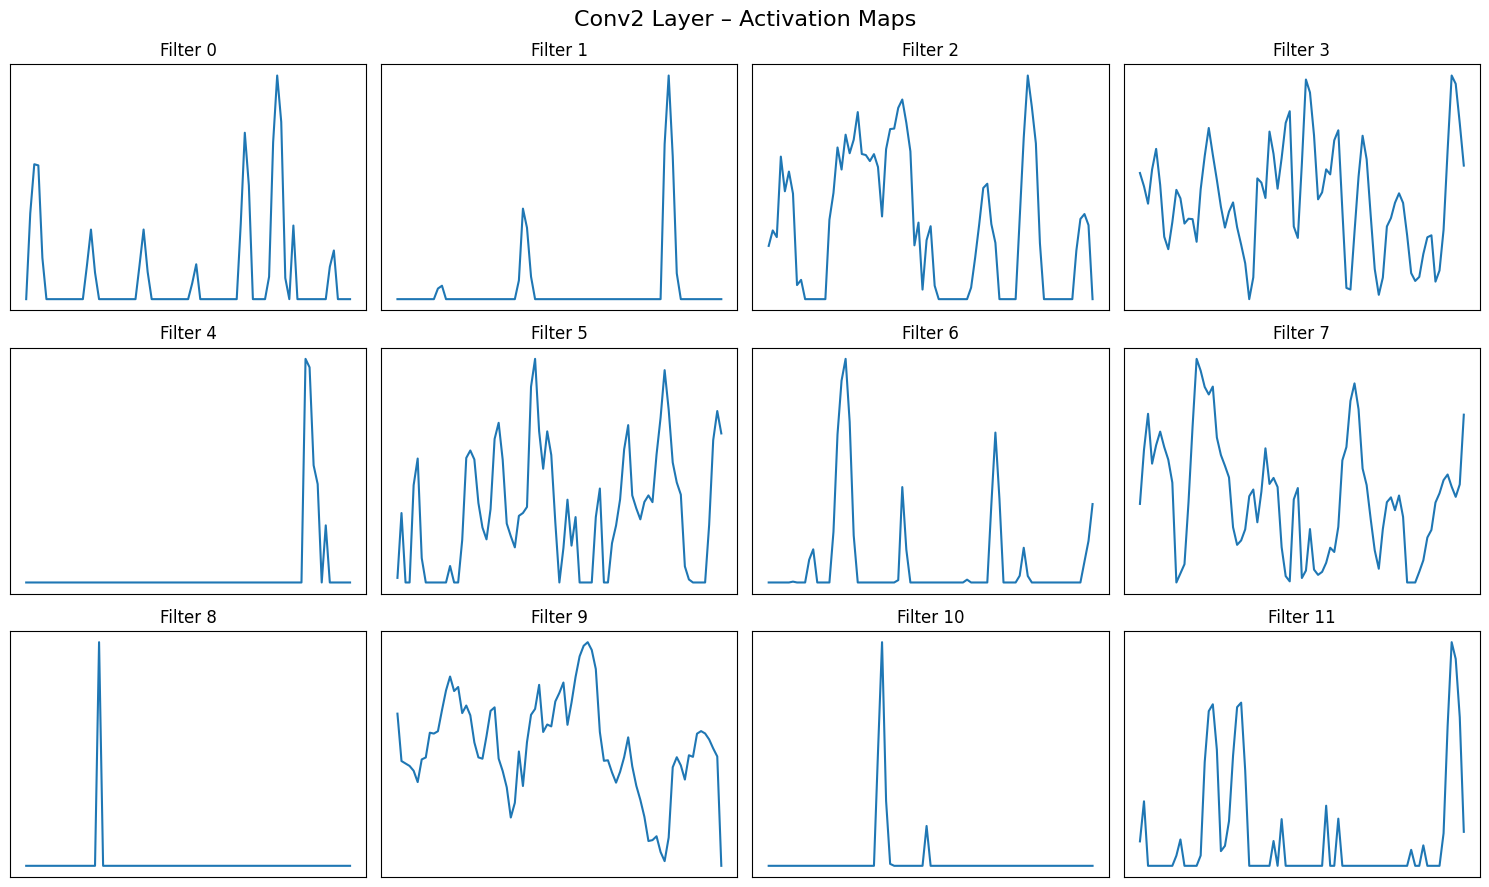

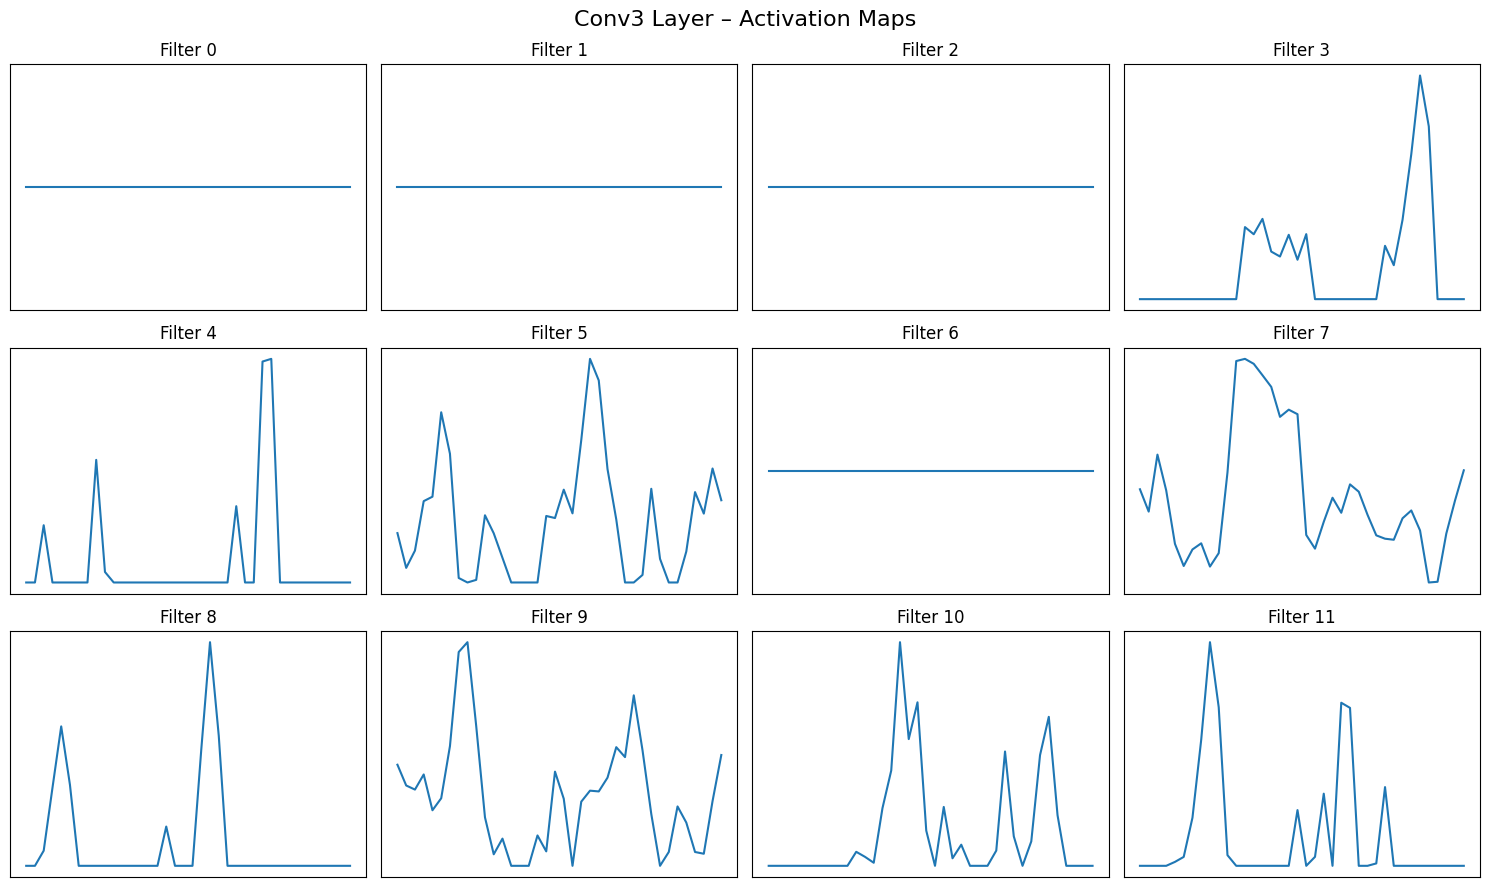

In [ ]:
plot_conv_layer_activations(activations[0], "Conv1 Layer", max_filters=12)
plot_conv_layer_activations(activations[1], "Conv2 Layer", max_filters=12)
plot_conv_layer_activations(activations[2], "Conv3 Layer", max_filters=12)

The activation maps across Conv1, Conv2, and Conv3 show that lower layers capture broad low-level temporal patterns, while deeper layers extract more focused and discriminative peaks relevant to MFCC-based sound structure. Several filters remain flat, indicating unused kernels, but the active ones clearly respond strongly to transient and periodic energy patterns in the audio signal.

# 2D CNN

In [ ]:
import librosa
import os
from tqdm import tqdm
import cv2

# Get metadata
df = pd.read_csv(METADATA_PATH)

def create_spectrogram_images(dataframe):
    X = []
    y = []

    # Expected length for padding (4 seconds * 22050 Hz)
    EXPECTED_SAMPLES = 4 * 22050

    print("Converting Audio to Spectrograms...")

    # Iterate through the CSV
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):

        # Construct the full path to the .wav file
        # Structure is usually: audio/fold1/100032-3-0-0.wav
        file_name = row['slice_file_name']
        fold_num = row['fold']
        file_path = os.path.join(AUDIO_PATH, f"fold{fold_num}", file_name)

        try:
            # Load Audio
            data, sample_rate = librosa.load(file_path)

            # Pad or Truncate to ensure all images are same width
            if len(data) > EXPECTED_SAMPLES:
                data = data[:EXPECTED_SAMPLES]
            else:
                padding = EXPECTED_SAMPLES - len(data)
                data = np.pad(data, (0, padding), 'constant')

            # Create Mel Spectrogram
            mels = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
            log_mels = librosa.power_to_db(mels, ref=np.max)

            # Resize to standard 128x128 image
            img_resized = cv2.resize(log_mels, (128, 128))

            X.append(img_resized)
            y.append(row['classID'])

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    return np.array(X), np.array(y)

# Creates X_images
X_images, y_labels = create_spectrogram_images(df)

# Add the "channel" dimension: (N, 128, 128) -> (N, 128, 128, 1)
X_images = X_images.reshape(X_images.shape[0], 128, 128, 1)

print("Data shape:", X_images.shape)

In [ ]:
# uncomment the code to save spectrogram data in drive
# X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2)

DATA_PATH = "/content/drive/MyDrive/data.npz"

# np.savez_compressed(
#     DATA_PATH ,
#     X_train=X_train,
#     X_test=X_test,
#     y_train=y_train,
#     y_test=y_test
# )

loaded = np.load(DATA_PATH)

X_train = loaded["X_train"]
X_test  = loaded["X_test"]
y_train = loaded["y_train"]
y_test  = loaded["y_test"]

X_train.shape, X_test.shape

((6985, 128, 128, 1), (1747, 128, 128, 1))

In [ ]:
from tensorflow.keras import layers, models, Input, callbacks, optimizers

def build_advanced_2d_cnn():
    model = models.Sequential([
        Input(shape=(128, 128, 1)),

        # -- Block 1 (Detailed Features) --
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # Double Conv
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),

        # -- Block 2 (Shapes) --
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # -- Block 3 (Complex Textures) --
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        # -- Block 4 (Deep Abstract Patterns) --
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        # GlobalAveragePooling
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(10, activation='softmax')
    ])

    # learning rate
    opt = optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
model_advanced = build_advanced_2d_cnn()
history = model_advanced.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[reduce_lr]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.2961 - loss: 2.0652 - val_accuracy: 0.1267 - val_loss: 2.7122 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5654 - loss: 1.2311 - val_accuracy: 0.3901 - val_loss: 1.8314 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6757 - loss: 0.9235 - val_accuracy: 0.5283 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.7558 - loss: 0.7226 - val_accuracy: 0.5483 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.7987 - loss: 0.5883 - val_accuracy: 0.6829 - val_loss: 1.2317 - learning_rate: 0.0010
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8573 - loss: 0.4397 - val_accuracy: 0.7366 - val_loss: 0.8558 - learning_rate: 0.0010
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8700 - loss: 0.38

In [ ]:
test_loss, test_acc = model_advanced.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 95.99%


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.98      0.97      0.98       175
        car_horn       1.00      0.97      0.99        75
children_playing       0.90      0.95      0.92       188
        dog_bark       0.96      0.98      0.97       191
        drilling       0.96      0.90      0.93       206
   engine_idling       0.99      0.98      0.99       211
        gun_shot       0.95      0.99      0.97        82
      jackhammer       0.92      0.99      0.95       224
           siren       0.98      0.99      0.98       198
    street_music       0.99      0.91      0.95       197

        accuracy                           0.96      1747
       macro avg       0.96      0.96      0.96      1747
    weighted avg       0.96      0.96      0.96      1747



<Figure size 1200x1000 with 0 Axes>

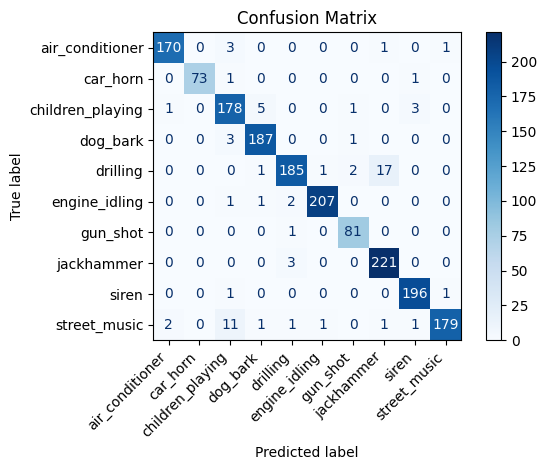

In [ ]:
y_pred_probs = model_advanced.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

class_names = le.classes_

print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


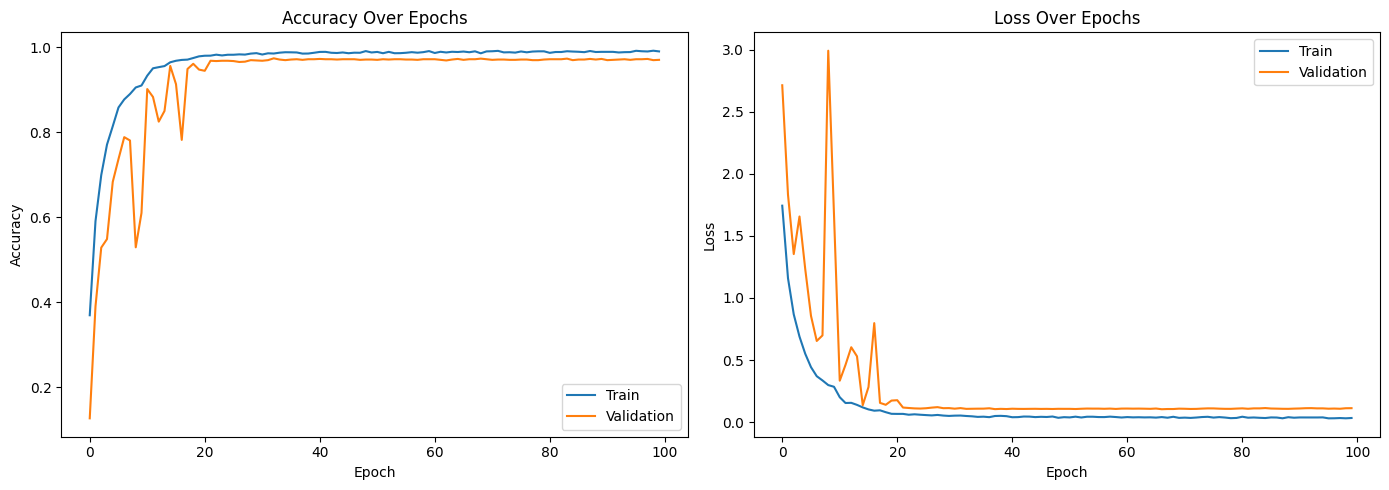

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

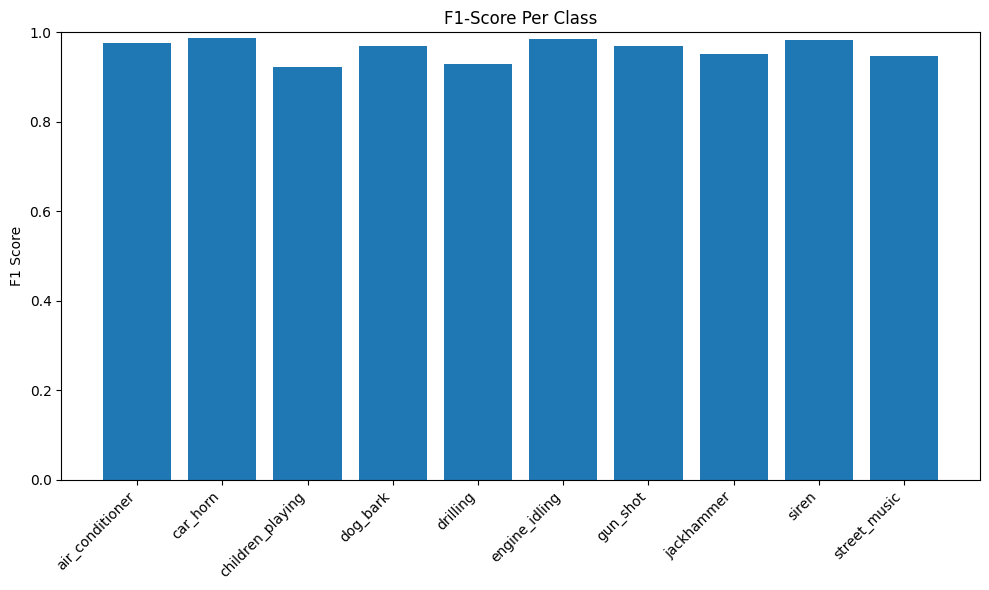

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_labels, labels=class_names
)

plt.figure(figsize=(10,6))
plt.bar(class_names, f1)
plt.xticks(rotation=45, ha='right')
plt.title("F1-Score Per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 📊 Observation: 2D CNN

Based on the provided graphs and reports, the final model demonstrates excellent performance, learning stability, and high generalization capability on the urban sound classification task.

---

## 1. Performance Overview

The model achieved an outstanding final accuracy and overall score:

* **Overall Accuracy:** **$0.96$** (or $96\%$).
* **Macro/Weighted Average F1-score:** **$0.96$**.

### Classification Report Summary

| Class | Precision | Recall | F1-Score | Support |
| :--- | :--- | :--- | :--- | :--- |
| **car\_horn** | **1.00** | 0.97 | **0.99** | 75 |
| **engine\_idling** | 0.99 | 0.98 | **0.99** | 211 |
| **siren** | 0.98 | 0.99 | **0.98** | 198 |
| **air\_conditioner** | 0.98 | 0.97 | **0.98** | 175 |
| **gun\_shot** | 0.95 | 0.99 | **0.97** | 82 |
| **Lowest F1-Score:** | children\_playing | 0.90 | 0.95 | 0.92 | 188 |


---

## 2. Confusion Matrix Analysis

The confusion matrix confirms the high performance by showing strong counts along the diagonal (True Positives).

| True Label | Predicted Label | Count |
| :--- | :--- | :--- |
| **engine\_idling** | engine\_idling | **207** |
| **jackhammer** | jackhammer | **221** |
| **siren** | siren | **196** |
| **street\_music** | street\_music | 179 |

### Misclassification Patterns

The errors are minimal and concentrated in a few specific classes:

* **'drilling'** has the lowest recall ($\mathbf{0.90}$) due to 12 instances being misclassified as **'jackhammer'** and 5 as **'engine\_idling'**. This is acoustically sensible as these sounds share rhythmic, mechanical characteristics.
* **'street\_music'** has the second-lowest recall ($\mathbf{0.91}$), with 11 instances misclassified as **'children\_playing'** and 2 as **'air\_conditioner'**.
* **'children\_playing'** has the lowest precision ($\mathbf{0.90}$), primarily receiving false positives from **'street\_music'** (11 instances), confirming the bi-directional confusion between these two categories.

---

## 3. Training Dynamics (Accuracy and Loss)

The **Accuracy Over Epochs** and **Loss Over Epochs** graphs  demonstrate excellent learning behavior and model stability:

### Accuracy (Left Plot)

* **Rapid Learning:** Both training (blue) and validation (orange) accuracy increase steeply within the first **20 epochs**, quickly reaching a high performance plateau ($\approx 0.98$ for train, $\approx 0.97$ for validation).
* **High Generalization:** The training and validation accuracy curves track each other very closely after the initial rapid phase, indicating a **well-generalized model** with minimal overfitting.

### Loss (Right Plot)

* **Sharp Decrease:** The loss for both train and validation drops dramatically within the first **20-30 epochs**.
* **Stability:** After epoch 30, both loss curves flatten out to near-zero values and remain extremely stable for the duration of the training (up to 100 epochs).
* **Low Overfitting:** The validation loss (orange) remains slightly above the training loss (blue) but maintains a very narrow gap, confirming that the model has successfully learned the data's structure without fitting noise.

**Conclusion on Dynamics:** The model converges quickly and demonstrates strong stability, suggesting that the selected architecture and hyperparameters were highly effective in achieving optimal performance and generalization.

# Autogluon (Tabular)

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# Split data into train and test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Initialize TabularPredictor
predictor = TabularPredictor(label='label', eval_metric='accuracy').fit(
    train_data=train_data,
    presets='best_quality',
    time_limit=3600
)

# Evaluate on test data
performance = predictor.evaluate(test_data)
y_pred = predictor.predict(test_data)


No path specified. Models will be saved in: "AutogluonModels/ag-20251201_224834"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.83 GB / 12.67 GB (85.5%)
Disk Space Avail:   63.13 GB / 107.72 GB (58.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_l

In [ ]:
performance

{'accuracy': 0.9622209502003435,
 'balanced_accuracy': np.float64(0.9615042028616895),
 'mcc': np.float64(0.9576767179013693)}

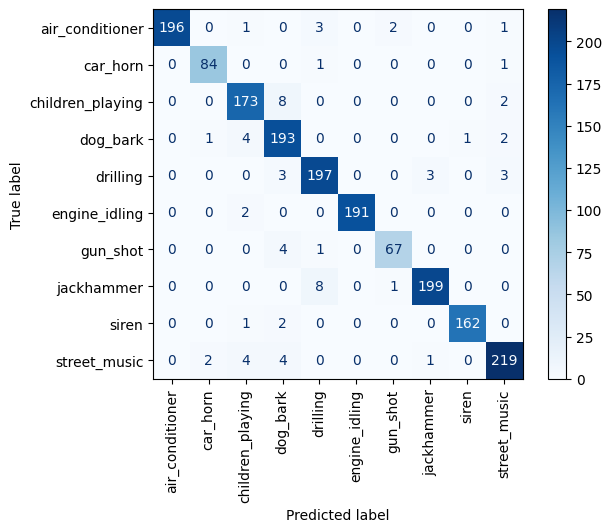

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = test_data['label']
y_pred = predictor.predict(test_data)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', xticks_rotation=90)




## **Observation (Confusion Matrix)**

The model performs **strongly across all 10 classes**, with most predictions on the diagonal. Classes like *air_conditioner, dog_bark, drilling, engine_idling,* and *street_music* show very high accuracy. Only minor confusions occur between acoustically similar sounds (e.g., *children_playing ↔ dog_bark*, *siren ↔ street_music*). Overall, the confusion matrix indicates **excellent class-wise performance and good generalization**.



In [ ]:
predictor.leaderboard(test_data, extra_metrics=['accuracy', 'f1_macro'])


model  score_test  accuracy  f1_macro  score_val  \
0   NeuralNetFastAI_BAG_L2    0.964511  0.964511  0.964667   0.957051   
1          LightGBM_BAG_L2    0.963366  0.963366  0.964069   0.956621   
2        LightGBMXT_BAG_L2    0.962221  0.962221  0.962197   0.957480   
3      WeightedEnsemble_L3    0.962221  0.962221  0.962197   0.957480   
4   NeuralNetFastAI_BAG_L1    0.959359  0.959359  0.958457   0.941446   
5      WeightedEnsemble_L2    0.953062  0.953062  0.953666   0.949606   
6        LightGBMXT_BAG_L1    0.944476  0.944476  0.945914   0.943164   
7          LightGBM_BAG_L1    0.934173  0.934173  0.933671   0.926700   
8  RandomForestEntr_BAG_L1    0.915856  0.915856  0.918301   0.907087   
9  RandomForestGini_BAG_L1    0.912421  0.912421  0.913450   0.908375   

  eval_metric  pred_time_test  pred_time_val     fit_time  \
0    accuracy       29.526981      26.732332  1881.659178   
1    accuracy       29.808849      26.506735  1949.471120   
2    accuracy       32.168014      28.980016  2216.902092   
3    accuracy       32.173370      28.983954  2217.366223   
4    accuracy        0.740225       0.345839   138.232820   
5    accuracy       21.343281      18.169957   991.375431   
6    accuracy       20.293267      16.691377   795.314018   
7    accuracy        7.289913       6.433276   699.887640   
8    accuracy        0.302860       1.129334    57.507094   
9    accuracy        0.388067       1.502980    38.158592   

   pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  \
0                 0.512649                0.629525         152.559013   
1                 0.794516                0.403928         220.370955   
2                 3.153681                2.877209         487.801928   
3                 0.005356                0.003938           0.464131   
4                 0.740225                0.345839         138.232820   
5                 0.006928                0.003407           0.321499   
6                20.293267               16.691377         795.314018   
7                 7.289913                6.433276         699.887640   
8                 0.302860                1.129334          57.507094   
9                 0.388067                1.502980          38.158592   

   stack_level  can_infer  fit_order  
0            2       True          7  
1            2       True          9  
2            2       True          8  
3            3       True         10  
4            1       True          1  
5            2       True          6  
6            1       True          2  
7            1       True          3  
8            1       True          5  
9            1       True          4

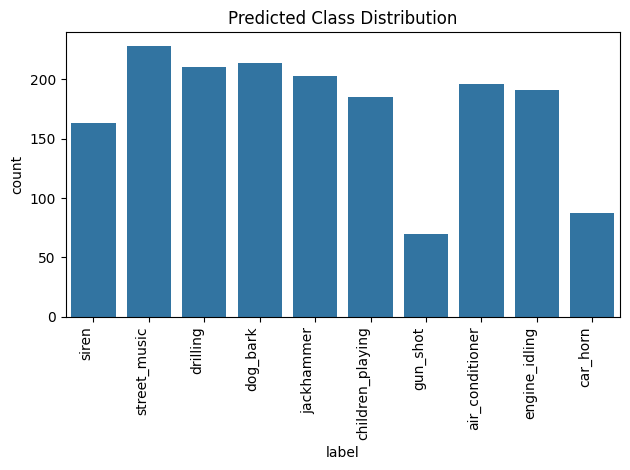

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()



# Predict Sample Audio

In [ ]:
def predict_audio(file_path, predictor):
    try:
        all_features = extract_features_full(file_path)

        # Convert to DataFrame (same shape as training CSV)
        feature_df = pd.DataFrame([all_features])

        feature_df.columns = (
            [f"mfcc_{i}" for i in range(120)] +
            [f"chroma_{i}" for i in range(12)] +
            ["centroid", "bandwidth", "rolloff", "zcr", "rms"]
        )

        feature_df.columns = [str(c) for c in feature_df.columns]

        # Predict
        prediction = predictor.predict(feature_df)[0]
        proba = predictor.predict_proba(feature_df)

        return prediction, proba

    except Exception as e:
        print("Error:", e)
        return None, None


In [ ]:
import soundfile as sf

# conversion of mp3 to wav format
y, sr = librosa.load("/content/drive/MyDrive/dog-bark-1.mp3", sr=22050)
sf.write("/content/drive/MyDrive/dog-bark-1-wav.wav", y, sr)

label, proba = predict_audio("/content/drive/MyDrive/dog-bark-1-wav.wav", predictor)
print("Predicted class:", label)
print("Class probabilities:\n", proba)

Predicted class: dog_bark
Class probabilities:
    air_conditioner  car_horn  children_playing  dog_bark  drilling  \
0          0.00447  0.003019          0.015926  0.926939  0.009141   

   engine_idling  gun_shot  jackhammer     siren  street_music  
0       0.009197  0.006029    0.004136  0.008115      0.013029  
